In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [2]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp

Using TensorFlow backend.


In [3]:
chr11 = '/nfs/kitzman3/lab_common/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 0 ]

In [4]:
data_in = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [5]:
byvartbl_long = pd.read_table( data_in + 'wt1_ex9_by_var_effects_snvs-2022-0609.txt' )

In [6]:
#extra variants in 5' end of intronic region - just get rid of them right away bc they're confusing
byvartbl_long = byvartbl_long.loc[ byvartbl_long.pos >= 1227 ].copy()

In [7]:
byvartbl_long

,chrom,pos,ref,alt,varlist,sample,n_bc,n_bc_passfilt,sum_reads,sum_reads_passfilt,...,per_bad_starts,per_bad_ends,per_soft_clipped,per_other_isoform,per_usable_reads,hgvs_pos,hg19_pos,exon_num,ref_c,alt_c
20,jkp815,1227,G,T,jkp815:1227:C:A,BB_test_Cos1053_JKLab0340_MM1B,88,65,8202,7711,...,0.090779,0.142653,0.0,0.038905,99.675788,c.1355-40,32413650,9,C,A
21,jkp815,1227,G,C,jkp815:1227:C:G,BB_test_Cos1053_JKLab0340_MM1B,57,47,5147,4973,...,0.160869,0.120652,0.0,0.100543,99.416851,c.1355-40,32413650,9,C,G
22,jkp815,1227,G,A,jkp815:1227:C:T,BB_test_Cos1053_JKLab0340_MM1B,68,53,6175,5930,...,0.202361,0.134907,0.0,0.000000,99.527825,c.1355-40,32413650,9,C,T
23,jkp815,1228,T,G,jkp815:1228:A:C,BB_test_Cos1053_JKLab0340_MM1B,67,44,7909,7654,...,0.130651,0.104521,0.0,0.091455,99.490463,c.1355-39,32413649,9,A,C
24,jkp815,1228,T,C,jkp815:1228:A:G,BB_test_Cos1053_JKLab0340_MM1B,45,34,10332,10206,...,0.097982,0.156771,0.0,0.058789,99.617872,c.1355-39,32413649,9,A,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17910,jkp815,1398,A,G,jkp815:1398:T:C,BB_RT_3_ODT_335_Hek1055,84,57,279,252,...,0.000000,0.000000,0.0,0.000000,100.000000,c.1447+39,32413479,9,T,C
17911,jkp815,1398,A,C,jkp815:1398:T:G,BB_RT_3_ODT_335_Hek1055,64,46,228,210,...,0.000000,1.904762,0.0,0.000000,98.095238,c.1447+39,32413479,9,T,G
17912,jkp815,1399,A,T,jkp815:1399:T:A,BB_RT_3_ODT_335_Hek1055,48,30,178,160,...,0.625000,0.625000,0.0,0.000000,98.750000,c.1447+40,32413478,9,T,A
17913,jkp815,1399,A,G,jkp815:1399:T:C,BB_RT_3_ODT_335_Hek1055,39,26,123,110,...,0.000000,0.000000,0.0,0.000000,100.000000,c.1447+40,32413478,9,T,C


In [8]:
bybc_tbl_l = ! ls /nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/wt1_ex9_*_by_bc_effects_allvars-2022-0609.txt

In [9]:
bybc_tbl_fn = { tbl.split( '/' )[ -1 ].split( '_' )[ 2 ]: pd.read_table( tbl )
                for tbl in bybc_tbl_l }

In [10]:
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ ( bybc_tbl_fn[ lib ].n_variants_passing == 1 ) ].copy()

In [11]:
for lib in bybc_tbl_fn:
    
    print( lib )
    
    print( bybc_tbl_fn[ lib ] )

JKP1053
                         barcode                          sample  passes  \
3        TGAGTTATGATTGTAGCTGATGG  BB_test_Cos1053_JKLab0340_MM1B    True   
7        TGAGTTATGGTCAGGTCGGGTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
11       TGAGTTAGTCGACATGAATCTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
13       TGAGTTCTCTTATGCGTGTTTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
23       ATTAGCATCGAGTAGCAACTTGG  BB_test_Cos1053_JKLab0340_MM1B    True   
...                          ...                             ...     ...   
1569542  ATTGTTATGATCAGCGTTGTTGG         BB_RT_1_ODT_335_Hek1053    True   
1569555  ATTGTGGTAGGTCAGTTTCCTGG         BB_RT_1_ODT_335_Hek1053    True   
1569558  ATTGTGTTCTGAAAGTCGTATGG         BB_RT_1_ODT_335_Hek1053    True   
1569561  ATTGTGTGTTTGACGTGCTCTGG         BB_RT_1_ODT_335_Hek1053    True   
1569562  ATTGTTAGGTTGATGGCGCTTGG         BB_RT_1_ODT_335_Hek1053    True   

        refname status  n_variants_passing                  variant_list  \
3  

In [12]:
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ][ 'pos' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: int( x.split( ':' )[ 1 ] ) )
    bybc_tbl_fn[ lib ][ 'ref' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: x.split( ':' )[ 2 ] )
    bybc_tbl_fn[ lib ][ 'alt' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: x.split( ':' )[ 3 ] )

In [13]:
#only want SNV BCs within the region of interest
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].pos >= 1227 ].copy()
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].ref.str.len() == 1 ].copy()
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].alt.str.len() == 1 ].copy()

In [14]:
bybc_tbl_fn[ 'JKP1053' ][ 'sample' ].unique()

array(['BB_test_Cos1053_JKLab0340_MM1B', 'BB_test_Cos1053_JKLab0340_MM2B',
       'BB_test_Cos1053_oligodT_MM1B', 'BB_test_Cos1053_oligodT_MM2B',
       'BB_RT_1_340_243_Cos1053', 'BB_RT_1_340_243_Hek1053',
       'BB_RT_1_340_335_Cos1053', 'BB_RT_1_340_335_Hek1053',
       'BB_RT_1b_340_243_Hek1053', 'BB_RT_1b_340_335_Hek1053',
       'BB_RT_1b_ODT_243_Hek1053', 'BB_RT_1b_ODT_335_Hek1053',
       'BB_RT_1_ODT_243_Cos1053', 'BB_RT_1_ODT_243_Hek1053',
       'BB_RT_1_ODT_335_Cos1053', 'BB_RT_1_ODT_335_Hek1053'], dtype=object)

In [15]:
#we did <,> 20 bp for POU1F1 but had more intronic context
#here we only have 40 bp on each side - so lets only give 10 bp on each side
bybc_int_tbl_fn = { lib: bybc_tbl_fn[ lib ].loc[ ( bybc_tbl_fn[ lib ].pos < 1257 ) | ( bybc_tbl_fn[ lib ].pos > 1369 ) ].copy()
                    for lib in bybc_tbl_fn }

In [16]:
bybc_int_tbl_fn[ 'JKP1053' ][ 'sample' ].unique()

array(['BB_test_Cos1053_JKLab0340_MM1B', 'BB_test_Cos1053_JKLab0340_MM2B',
       'BB_test_Cos1053_oligodT_MM1B', 'BB_test_Cos1053_oligodT_MM2B',
       'BB_RT_1_340_243_Cos1053', 'BB_RT_1_340_243_Hek1053',
       'BB_RT_1_340_335_Cos1053', 'BB_RT_1_340_335_Hek1053',
       'BB_RT_1b_340_243_Hek1053', 'BB_RT_1b_340_335_Hek1053',
       'BB_RT_1b_ODT_243_Hek1053', 'BB_RT_1b_ODT_335_Hek1053',
       'BB_RT_1_ODT_243_Cos1053', 'BB_RT_1_ODT_243_Hek1053',
       'BB_RT_1_ODT_335_Cos1053', 'BB_RT_1_ODT_335_Hek1053'], dtype=object)

In [17]:
read_cut_unfilt = pd.read_table( data_in + 'n_bcs_bysamp.2022-0609.txt' )

In [18]:
cut_dict = { samp: cut for samp,cut in zip( read_cut_unfilt[ 'sample' ], read_cut_unfilt[ '95_y' ] ) }

In [19]:
#these were removed so as to not influence the regression - add manually from wt1_byiso.2022-0609
cut_dict[ 'BB_test_Cos1053_JKLab0340_MM1B' ] = 38
cut_dict[ 'BB_test_Cos1053_JKLab0340_MM2B' ] = 89
cut_dict[ 'BB_test_Cos1053_oligodT_MM1B' ] = 30
cut_dict[ 'BB_test_Cos1053_oligodT_MM2B' ] = 92

In [20]:
cut_dict

{'BB_RT_1_340_243_Cos1053': 12,
 'BB_RT_1_340_243_Hek1053': 3,
 'BB_RT_1_340_335_Cos1053': 14,
 'BB_RT_1_340_335_Hek1053': 3,
 'BB_RT_1b_340_243_Hek1053': 2,
 'BB_RT_1b_340_335_Hek1053': 3,
 'BB_RT_1b_ODT_243_Hek1053': 3,
 'BB_RT_1b_ODT_335_Hek1053': 2,
 'BB_RT_1_ODT_243_Cos1053': 17,
 'BB_RT_1_ODT_243_Hek1053': 4,
 'BB_RT_1_ODT_335_Cos1053': 11,
 'BB_RT_1_ODT_335_Hek1053': 4,
 'BB_RT_2_340_243_Cos1054': 39,
 'BB_RT_2_340_243_Hek1054': 4,
 'BB_RT_2_340_335_Cos1054': 32,
 'BB_RT_2_340_335_Hek1054': 4,
 'BB_RT_2_ODT_243_Cos1054': 42,
 'BB_RT_2_ODT_243_Hek1054': 5,
 'BB_RT_2_ODT_335_Cos1054': 28,
 'BB_RT_2_ODT_335_Hek1054': 3,
 'BB_RT_3_340_243_Cos1055': 1,
 'BB_RT_3_340_243_Hek1055': 1,
 'BB_RT_3_340_335_Cos1055': 1,
 'BB_RT_3_340_335_Hek1055': 1,
 'BB_RT_3_ODT_243_Cos1055': 2,
 'BB_RT_3_ODT_243_Hek1055': 1,
 'BB_RT_3_ODT_335_cos1055': 2,
 'BB_RT_3_ODT_335_Hek1055': 1,
 'BB_test_Cos1053_JKLab0340_MM1B': 38,
 'BB_test_Cos1053_JKLab0340_MM2B': 89,
 'BB_test_Cos1053_oligodT_MM1B': 30,
 'BB_

In [21]:
#same filtering we did during processing to remove low read BCs that could be too influential
bybc_int_tbl_fn_filt_bysamp = { lib: { samp: bybc_int_tbl_fn[ lib ].loc[ ( bybc_int_tbl_fn[ lib ][ 'sample' ] == samp ) & ( bybc_int_tbl_fn[ lib ].usable_reads > cut_dict[ samp ] ) ].copy()
                                       for samp in cut_dict }
                                for lib in bybc_int_tbl_fn }

In [22]:
bybc_int_tbl_fn_filt = { lib: pd.concat( [ bybc_int_tbl_fn_filt_bysamp[ lib ][ samp ] for samp in bybc_int_tbl_fn_filt_bysamp[ lib ] ] )
                         for lib in bybc_int_tbl_fn_filt_bysamp }

In [23]:
bybc_int_tbl_fn_filt[ 'JKP1053' ]

,barcode,sample,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,...,KTS-,SKIP,OTHER,KTS+_psi,KTS-_psi,SKIP_psi,OTHER_psi,pos,ref,alt
79849,TGAGTTATGATTGTAGCTGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1231:G:C,0.634021,-1.0,123,...,0,1,0,0.950000,0.000000,0.050000,0.000000,1231,G,C
79862,TGAGTTCTGTGTTATCGATTTGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1249:C:G,0.612040,-1.0,183,...,23,5,0,0.719101,0.258427,0.056180,0.000000,1249,C,G
79869,ATTAGGGCTGTTGTTCATGGTGGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:T,0.666667,-1.0,124,...,1,0,0,0.954545,0.045455,0.000000,0.000000,1227,C,T
79873,ATTAGATCGTGACGCCCGGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:A,0.804348,-1.0,37,...,46,0,0,0.041667,0.958333,0.000000,0.000000,1227,C,A
79884,ATTAGAGTTTACCGAAGTTATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1392:T:A,0.614583,-1.0,118,...,29,0,0,0.033333,0.966667,0.000000,0.000000,1392,T,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79709,GATGTCAATAAGACGTTGTGTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1379:C:G,0.641026,-1.0,50,...,144,2,0,0.046980,0.966443,0.013423,0.000000,1379,C,G
79730,TTTCGACCTAGAAATCCACTTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1378:A:C,0.666667,-1.0,56,...,131,4,0,0.490566,0.494340,0.015094,0.000000,1378,A,C
79745,TCGAGGGTGTCGTGTAACATTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1375:T:A,0.711538,-1.0,74,...,4,5,2,0.943590,0.020513,0.025641,0.010256,1375,T,A
79746,TCGAGTCTTAGCTCGTGGGTTGG,BB_test_Cos1053_oligodT_MM2B,True,jkp815,pass,1,jkp815:1399:T:G,0.769231,-1.0,10,...,9,6,0,0.904459,0.057325,0.038217,0.000000,1399,T,G


In [24]:
byvartbl_long = byvartbl_long.loc[ byvartbl_long.n_bc_passfilt > 0 ] .copy()

In [25]:
bybc_int_tbl = pd.concat( [ bybc_int_tbl_fn_filt[ lib ] for lib in bybc_int_tbl_fn_filt ] )

In [26]:
bybc_int_tbl

,barcode,sample,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,...,KTS-,SKIP,OTHER,KTS+_psi,KTS-_psi,SKIP_psi,OTHER_psi,pos,ref,alt
79849,TGAGTTATGATTGTAGCTGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1231:G:C,0.634021,-1.0,123,...,0,1,0,0.950000,0.000000,0.050000,0.0,1231,G,C
79862,TGAGTTCTGTGTTATCGATTTGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1249:C:G,0.612040,-1.0,183,...,23,5,0,0.719101,0.258427,0.056180,0.0,1249,C,G
79869,ATTAGGGCTGTTGTTCATGGTGGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:T,0.666667,-1.0,124,...,1,0,0,0.954545,0.045455,0.000000,0.0,1227,C,T
79873,ATTAGATCGTGACGCCCGGATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1227:C:A,0.804348,-1.0,37,...,46,0,0,0.041667,0.958333,0.000000,0.0,1227,C,A
79884,ATTAGAGTTTACCGAAGTTATGG,BB_RT_1_340_243_Cos1053,True,jkp815,pass,1,jkp815:1392:T:A,0.614583,-1.0,118,...,29,0,0,0.033333,0.966667,0.000000,0.0,1392,T,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571893,GTGGGCTTGGCGGTTTAATATGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1228:A:T,0.765432,-1.0,62,...,3,0,0,0.000000,1.000000,0.000000,0.0,1228,A,T
1571905,GTGGGATATGTTTTGAGTGATGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1244:C:G,0.736842,-1.0,14,...,1,7,0,0.333333,0.083333,0.583333,0.0,1244,C,G
1571930,GTGGCTTTGTATATCCTGGTTGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1380:A:T,0.789474,-1.0,30,...,2,0,0,0.000000,1.000000,0.000000,0.0,1380,A,T
1571931,GTGGGACTATCGACTCAATGTGG,BB_RT_3_ODT_335_Hek1055,True,jkp815,pass,1,jkp815:1251:T:C,0.620690,-1.0,36,...,1,0,0,0.500000,0.500000,0.000000,0.0,1251,T,C


In [27]:
%%time
byvartbl_long_bs = pd.concat( [ pp.bootstrap_varsp_null_distribution( bybc_int_tbl.loc[ bybc_int_tbl[ 'sample' ] == samp ].set_index( 'barcode' ),
                                                                      byvartbl_long.loc[ ( byvartbl_long[ 'sample' ] == samp ) ] )
                              for samp in byvartbl_long[ 'sample' ].unique().tolist() ],
                              ignore_index = True ).drop( columns = [ 'index' ] )

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
CPU times: user 11.5 s, sys: 33.7 ms, total: 11.5 s
Wall time: 11.5 s


In [28]:
iso_names = [ 'KTS+', 'KTS-', 'SKIP', 'OTHER' ]

In [29]:
byvartbl_long_bs = pp.compute_null_zscores( byvartbl_long_bs,
                                            'bs_null', 
                                             iso_names )

In [30]:
%%time
byvartbl_long_bs = pd.concat( [ pp.compute_fold_change( byvartbl_long_bs.loc[ byvartbl_long_bs[ 'sample' ] == samp ],
                                                        'wmean_bs_null_',
                                                         'wmean_') 
                                                        for samp in byvartbl_long_bs[ 'sample' ].unique().tolist() ],
                                                        ignore_index = True ).sort_values( by = 'pos' )

CPU times: user 181 ms, sys: 91 µs, total: 181 ms
Wall time: 180 ms


In [31]:
byvartbl_long_bs.to_csv( data_in + 'wt1_ex9_by_var_effects_snvs-2022-0707.txt',
                         sep = '\t',
                         index = False )

In [32]:
byvartbl_wide_bs = mbcs.combine_rep_pervartbls_wide( [ byvartbl_long_bs.loc[ byvartbl_long_bs[ 'sample' ] == samp ][ [ col for col in byvartbl_long_bs if col != 'sample' and col != 'rep' ] ]
                                                    for samp in byvartbl_long_bs[ 'sample' ].unique() ],
                                                  [ samp for samp in byvartbl_long_bs[ 'sample' ].unique() ],
                                                  indexcols=[ 'chrom','pos','ref','ref_c','alt','alt_c','varlist','hg19_pos','hgvs_pos','exon_num' ], 
                                                  group_cols_by_samp = True )

In [33]:
byvartbl_wide = pd.read_table( data_in + 'wt1_ex9_by_var_effects_snvs_wide-2022-0621.txt' ) 

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (1203,1204,1205,1206,1207,1208) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
byvartbl_wide

,hgvs_pos,hg19_pos,ref,alt,ref_c,alt_c,pos,chrom,varlist,exon_num,...,splai_KTS+_ratio_log10,maxent_KTS+_nomiss,maxent_KTS-_nomiss,source,Interpretation_ACMG,human disease,other evidence,Reference,Comment,lit_var
0,c.1355-40,32413650,G,A,C,T,1227,11,jkp815:1227:C:T,9,...,NaN,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
1,c.1355-40,32413650,G,C,C,G,1227,11,jkp815:1227:C:G,9,...,NaN,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
2,c.1355-40,32413650,G,T,C,A,1227,11,jkp815:1227:C:A,9,...,NaN,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
3,c.1355-39,32413649,T,A,A,T,1228,11,jkp815:1228:A:T,9,...,NaN,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
4,c.1355-39,32413649,T,C,A,G,1228,11,jkp815:1228:A:G,9,...,NaN,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,c.1447+39,32413479,A,G,T,C,1398,11,jkp815:1398:T:C,9,...,-0.064919,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
514,c.1447+39,32413479,A,T,T,A,1398,11,jkp815:1398:T:A,9,...,-0.071990,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
515,c.1447+40,32413478,A,C,T,G,1399,11,jkp815:1399:T:G,9,...,-0.066454,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False
516,c.1447+40,32413478,A,G,T,C,1399,11,jkp815:1399:T:C,9,...,-0.066585,6.678108,8.594409,NaN,NaN,NaN,NaN,NaN,NaN,False


In [35]:
new_cols = list( byvartbl_wide_bs.columns.difference( byvartbl_wide.columns ) )

In [36]:
merge_idx = [ 'pos', 'ref', 'alt' ]

byvartbl_wide_m = byvartbl_wide.set_index( merge_idx ).merge( byvartbl_wide_bs.set_index( merge_idx )[ new_cols ],
                                                              how = 'outer',
                                                              left_index = True,
                                                              right_index = True ).reset_index()

In [37]:
byvartbl_wide_m

,pos,ref,alt,hgvs_pos,hg19_pos,ref_c,alt_c,chrom,varlist,exon_num,...,BB_test_Cos1053_oligodT_MM2B_wmean_bs_null_OTHER,BB_test_Cos1053_oligodT_MM2B_wmean_bs_null_SKIP,BB_test_Cos1053_oligodT_MM2B_wstdev_bs_null_KTS+,BB_test_Cos1053_oligodT_MM2B_wstdev_bs_null_KTS-,BB_test_Cos1053_oligodT_MM2B_wstdev_bs_null_OTHER,BB_test_Cos1053_oligodT_MM2B_wstdev_bs_null_SKIP,BB_test_Cos1053_oligodT_MM2B_zwmean_bs_null_KTS+,BB_test_Cos1053_oligodT_MM2B_zwmean_bs_null_KTS-,BB_test_Cos1053_oligodT_MM2B_zwmean_bs_null_OTHER,BB_test_Cos1053_oligodT_MM2B_zwmean_bs_null_SKIP
0,1227,G,A,c.1355-40,32413650,C,T,11,jkp815:1227:C:T,9,...,0.004286,0.085686,0.055019,0.050652,0.003976,0.039428,-0.780651,0.312916,-0.356215,0.577210
1,1227,G,C,c.1355-40,32413650,C,G,11,jkp815:1227:C:G,9,...,0.004420,0.085400,0.059783,0.057283,0.004578,0.043111,0.561961,-0.345187,3.273824,-0.662421
2,1227,G,T,c.1355-40,32413650,C,A,11,jkp815:1227:C:A,9,...,0.004319,0.085832,0.054071,0.051388,0.004090,0.039987,0.328671,-0.356426,-0.401204,0.038214
3,1228,T,A,c.1355-39,32413649,A,T,11,jkp815:1228:A:T,9,...,0.004420,0.085400,0.059783,0.057283,0.004578,0.043111,0.681708,-0.751960,-0.207735,0.089915
4,1228,T,C,c.1355-39,32413649,A,G,11,jkp815:1228:A:G,9,...,0.004342,0.084889,0.078904,0.075635,0.006134,0.055346,1.073038,-0.424638,-0.212390,-0.928396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,c.1447+39,32413479,T,C,11,jkp815:1398:T:C,9,...,0.004368,0.072351,0.210002,0.211548,0.019729,0.111906,-0.806479,0.976662,0.027900,-0.324250
514,1398,A,T,c.1447+39,32413479,T,A,11,jkp815:1398:T:A,9,...,0.004368,0.072351,0.210002,0.211548,0.019729,0.111906,0.105305,0.020547,0.509364,-0.353741
515,1399,A,C,c.1447+40,32413478,T,G,11,jkp815:1399:T:G,9,...,0.004069,0.076545,0.173438,0.171838,0.013864,0.100510,-0.199567,0.471458,-0.041042,-0.439498
516,1399,A,G,c.1447+40,32413478,T,C,11,jkp815:1399:T:C,9,...,0.002960,0.064661,0.415241,0.415170,0.004631,0.167125,-1.058938,1.083894,-0.639149,-0.056778


In [38]:
for iso in iso_names:
    
    byvartbl_wide_m[ 'fc_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m.columns if '_fc_' + iso in col ] ].median( axis = 1 )

In [39]:
for iso in iso_names:
    
    byvartbl_wide_m[ 'wmean_bs_null_' + iso ] = byvartbl_wide_m[ [ col for col in byvartbl_wide_m.columns if '_wmean_bs_null_' + iso in col ] ].median( axis = 1 )

In [40]:
byvartbl_wide_m = pp.stouffers_z( byvartbl_wide_m,
                                  iso_names,
                                  zcol = 'zwmean_bs_null_')

In [41]:
bonfer = .05 / ( 3*len( byvartbl_wide_m ) )

In [42]:
bonfer

3.217503217503218e-05

In [43]:
ss.norm.ppf( 1 - bonfer )

3.996263652603639

In [44]:
byvartbl_wide_m

,pos,ref,alt,hgvs_pos,hg19_pos,ref_c,alt_c,chrom,varlist,exon_num,...,fc_SKIP,fc_OTHER,wmean_bs_null_KTS+,wmean_bs_null_KTS-,wmean_bs_null_SKIP,wmean_bs_null_OTHER,zwmean_bs_null_KTS+,zwmean_bs_null_KTS-,zwmean_bs_null_SKIP,zwmean_bs_null_OTHER
0,1227,G,A,c.1355-40,32413650,C,T,11,jkp815:1227:C:T,9,...,1.191561,0.743456,0.457634,0.408342,0.129163,0.002187,-2.002126,-5.136229,4.973602,-1.873450
1,1227,G,C,c.1355-40,32413650,C,G,11,jkp815:1227:C:G,9,...,0.815926,0.808694,0.457623,0.408255,0.129227,0.002175,6.622351,2.818556,-6.413922,-0.036895
2,1227,G,T,c.1355-40,32413650,C,A,11,jkp815:1227:C:A,9,...,0.736701,0.866012,0.457489,0.408267,0.129343,0.002211,8.802748,4.748851,-9.102060,0.378136
3,1228,T,A,c.1355-39,32413649,A,T,11,jkp815:1228:A:T,9,...,1.185860,0.729469,0.457565,0.408163,0.129308,0.002175,-3.121433,-7.441169,7.388977,-1.869384
4,1228,T,C,c.1355-39,32413649,A,G,11,jkp815:1228:A:G,9,...,0.765033,0.972577,0.457467,0.408387,0.129197,0.002226,6.080339,1.920984,-5.528064,1.955259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,c.1447+39,32413479,T,C,11,jkp815:1398:T:C,9,...,0.555647,0.000000,0.459556,0.413527,0.124034,0.002149,1.071069,2.444888,-2.544955,-1.196672
514,1398,A,T,c.1447+39,32413479,T,A,11,jkp815:1398:T:A,9,...,0.621014,0.000000,0.461702,0.413532,0.125284,0.002136,0.922775,2.787915,-2.217009,-1.087807
515,1399,A,C,c.1447+40,32413478,T,G,11,jkp815:1399:T:G,9,...,0.663862,0.000000,0.460589,0.413888,0.125359,0.002332,3.742196,-0.972581,-1.977212,-1.155702
516,1399,A,G,c.1447+40,32413478,T,C,11,jkp815:1399:T:C,9,...,0.775795,0.000000,0.464352,0.411326,0.120151,0.002505,0.095831,0.667268,0.471389,-0.536184


KTS+


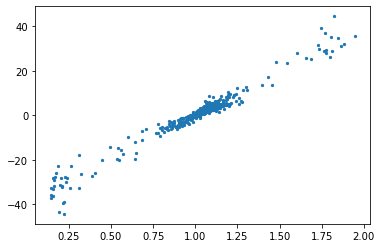

KTS-


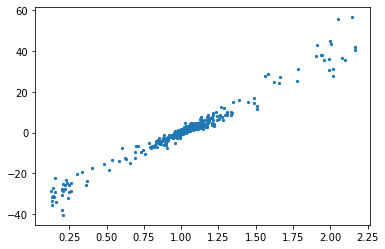

SKIP


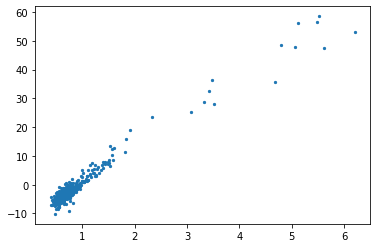

OTHER


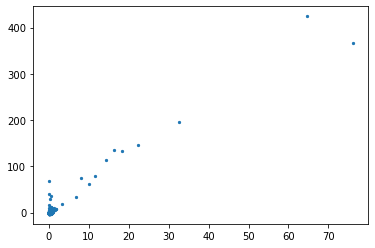

In [45]:
for iso in iso_names:
    
    print( iso )
    
    plt.scatter( byvartbl_wide_m[ 'fc_' + iso ],
                 byvartbl_wide_m[ 'zwmean_bs_null_' + iso ],
                 s = 5 )
    
    plt.ylim(  )
    
    plt.show()

In [97]:
byvartbl_wide_m.loc[ byvartbl_wide_m[ 'Interpretation_ACMG' ].isnull(), 'Interpretation_ACMG' ] = ''

In [98]:
byvartbl_wide_m[ 'Interpretation_ACMG' ].unique()

array(['', 'Likely benign', 'VUS', 'Pathogenic', 'Benign'], dtype=object)

In [105]:
byvartbl_wide_m[ 'lit_var_interp_num' ] = [ 10 if i == '' else( 20 if i == 'Benign' else ( 30 if i == 'Likely benign' else( 40 if i == 'VUS' else 50 ) ) ) for i in byvartbl_wide_m[ 'Interpretation_ACMG' ] ]

KTS+


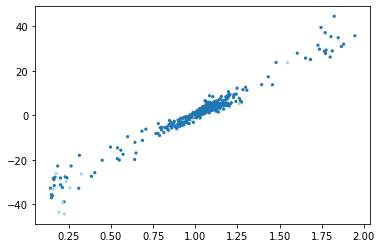

KTS-


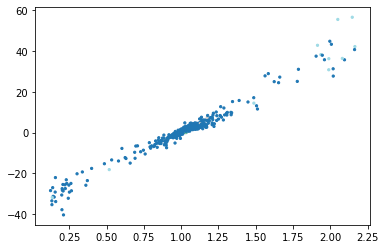

SKIP


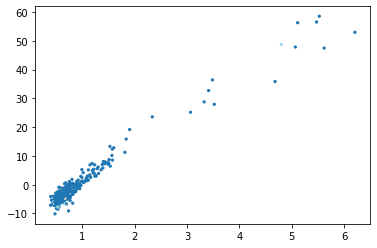

OTHER


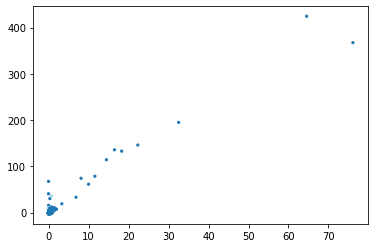

In [108]:
for iso in iso_names:
    
    print( iso )
    
    plt.scatter( byvartbl_wide_m[ 'fc_' + iso ],
                 byvartbl_wide_m[ 'zwmean_bs_null_' + iso ],
                 c = byvartbl_wide_m.lit_var_interp_num,
                 cmap = 'tab20',
                 s = 5 )
    
    plt.show()

In [47]:
byvartbl_wide_m = pp.sdv_by_iso( byvartbl_wide_m,
                                   iso_names,
                                   'zwmean_bs_null_',
                                   ss.norm.ppf( 1 - bonfer ),
                                   'fc_',
                                   2,
                                   out_col_stem = 'sdv_fc2+_',
                                   bi_directional = False
                                   )

In [48]:
byvartbl_wide_m

,pos,ref,alt,hgvs_pos,hg19_pos,ref_c,alt_c,chrom,varlist,exon_num,...,wmean_bs_null_SKIP,wmean_bs_null_OTHER,zwmean_bs_null_KTS+,zwmean_bs_null_KTS-,zwmean_bs_null_SKIP,zwmean_bs_null_OTHER,sdv_fc2+_KTS+,sdv_fc2+_KTS-,sdv_fc2+_SKIP,sdv_fc2+_OTHER
0,1227,G,A,c.1355-40,32413650,C,T,11,jkp815:1227:C:T,9,...,0.129163,0.002187,-2.002126,-5.136229,4.973602,-1.873450,False,False,False,False
1,1227,G,C,c.1355-40,32413650,C,G,11,jkp815:1227:C:G,9,...,0.129227,0.002175,6.622351,2.818556,-6.413922,-0.036895,False,False,False,False
2,1227,G,T,c.1355-40,32413650,C,A,11,jkp815:1227:C:A,9,...,0.129343,0.002211,8.802748,4.748851,-9.102060,0.378136,False,False,False,False
3,1228,T,A,c.1355-39,32413649,A,T,11,jkp815:1228:A:T,9,...,0.129308,0.002175,-3.121433,-7.441169,7.388977,-1.869384,False,False,False,False
4,1228,T,C,c.1355-39,32413649,A,G,11,jkp815:1228:A:G,9,...,0.129197,0.002226,6.080339,1.920984,-5.528064,1.955259,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,c.1447+39,32413479,T,C,11,jkp815:1398:T:C,9,...,0.124034,0.002149,1.071069,2.444888,-2.544955,-1.196672,False,False,False,False
514,1398,A,T,c.1447+39,32413479,T,A,11,jkp815:1398:T:A,9,...,0.125284,0.002136,0.922775,2.787915,-2.217009,-1.087807,False,False,False,False
515,1399,A,C,c.1447+40,32413478,T,G,11,jkp815:1399:T:G,9,...,0.125359,0.002332,3.742196,-0.972581,-1.977212,-1.155702,False,False,False,False
516,1399,A,G,c.1447+40,32413478,T,C,11,jkp815:1399:T:C,9,...,0.120151,0.002505,0.095831,0.667268,0.471389,-0.536184,False,False,False,False


In [49]:
byvartbl_wide_m[ 'sdv_fc2+' ] = byvartbl_wide_m[ [ 'sdv_fc2+_' + iso for iso in iso_names ] ].any( axis = 'columns' )

In [50]:
byvartbl_wide_m[ 'exon_sdv_fc2+' ] = ( byvartbl_wide_m.pos >= 1267 ) & ( byvartbl_wide_m.pos <= 1359 ) & ( byvartbl_wide_m[ 'sdv_fc2+' ] )
byvartbl_wide_m[ 'intron_sdv_fc2+' ] = ( ( byvartbl_wide_m.pos < 1267 ) | ( byvartbl_wide_m.pos > 1359 ) ) & ( byvartbl_wide_m[ 'sdv_fc2+' ] )

In [51]:
byvartbl_wide_m[ 'lit_var_sdv_fc2+' ] = ( byvartbl_wide_m.lit_var ) & ( byvartbl_wide_m[ 'sdv_fc2+' ] )

In [110]:
byvartbl_wide_m[ 'lit_var_path' ] = ( byvartbl_wide_m[ 'Interpretation_ACMG' ] == 'Pathogenic' ) 

In [111]:
byvartbl_wide_m[ 'lit_var_lbb' ] = ( byvartbl_wide_m[ 'Interpretation_ACMG' ] == 'Benign' ) | ( byvartbl_wide_m[ 'Interpretation_ACMG' ] == 'Likely benign' )

In [52]:
github_colors = '3182bd6baed69ecae1c6dbefe6550dfd8d3cfdae6bfdd0a231a35474c476a1d99bc7e9c0756bb19e9ac8bcbddcdadaeb636363969696bdbdbdd9d9d9'

In [53]:
light_colors = [ '#' + github_colors[i:i+6] for i in range( 0, len( github_colors ), 6 ) ]

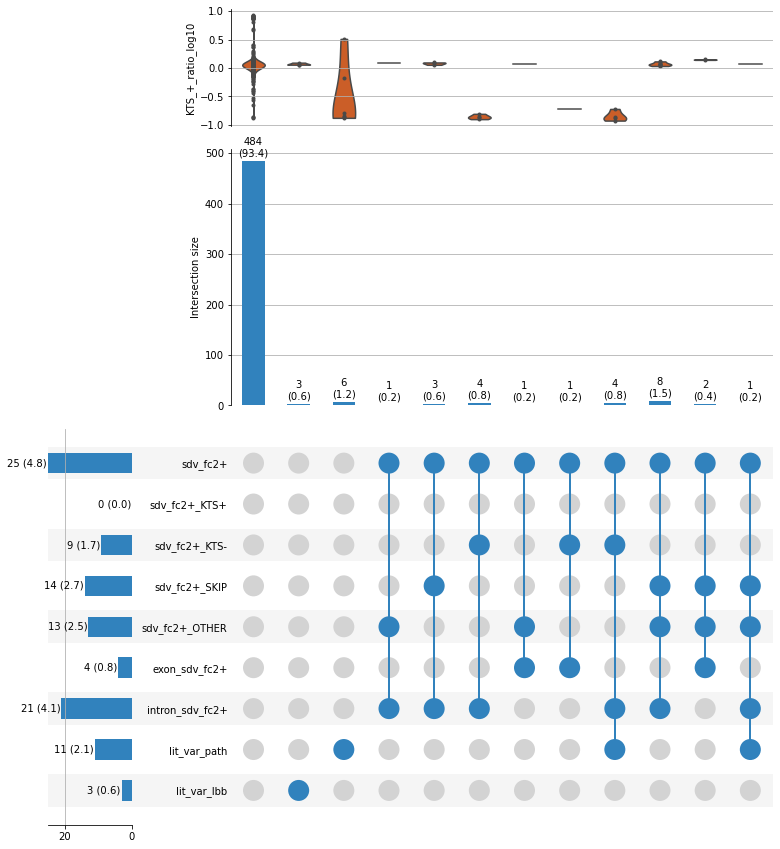

In [112]:
sp.upset_plot( byvartbl_wide_m, 
               [ 'sdv_fc2+', 'sdv_fc2+_KTS+', 'sdv_fc2+_KTS-', 'sdv_fc2+_SKIP', 'sdv_fc2+_OTHER', 'exon_sdv_fc2+', 'intron_sdv_fc2+', 'lit_var_path', 'lit_var_lbb' ][::-1],
                ( 14, 14 ),
                [ 'KTS_+_ratio_log10' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
              )

In [55]:
byvartbl_wide_m = pp.sdv_by_iso( byvartbl_wide_m,
                                   iso_names,
                                   'zwmean_bs_null_',
                                   ss.norm.ppf( 1 - bonfer ),
                                   'fc_',
                                   2,
                                   out_col_stem = 'sdv_fc2bi_',
                                   bi_directional = True
                                   )

In [56]:
byvartbl_wide_m

,pos,ref,alt,hgvs_pos,hg19_pos,ref_c,alt_c,chrom,varlist,exon_num,...,sdv_fc2+_SKIP,sdv_fc2+_OTHER,sdv_fc2+,exon_sdv_fc2+,intron_sdv_fc2+,lit_var_sdv_fc2+,sdv_fc2bi_KTS+,sdv_fc2bi_KTS-,sdv_fc2bi_SKIP,sdv_fc2bi_OTHER
0,1227,G,A,c.1355-40,32413650,C,T,11,jkp815:1227:C:T,9,...,False,False,False,False,False,False,False,False,False,False
1,1227,G,C,c.1355-40,32413650,C,G,11,jkp815:1227:C:G,9,...,False,False,False,False,False,False,False,False,False,False
2,1227,G,T,c.1355-40,32413650,C,A,11,jkp815:1227:C:A,9,...,False,False,False,False,False,False,False,False,False,False
3,1228,T,A,c.1355-39,32413649,A,T,11,jkp815:1228:A:T,9,...,False,False,False,False,False,False,False,False,False,False
4,1228,T,C,c.1355-39,32413649,A,G,11,jkp815:1228:A:G,9,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,c.1447+39,32413479,T,C,11,jkp815:1398:T:C,9,...,False,False,False,False,False,False,False,False,False,False
514,1398,A,T,c.1447+39,32413479,T,A,11,jkp815:1398:T:A,9,...,False,False,False,False,False,False,False,False,False,False
515,1399,A,C,c.1447+40,32413478,T,G,11,jkp815:1399:T:G,9,...,False,False,False,False,False,False,False,False,False,False
516,1399,A,G,c.1447+40,32413478,T,C,11,jkp815:1399:T:C,9,...,False,False,False,False,False,False,False,False,False,False


In [57]:
byvartbl_wide_m[ 'sdv_fc2bi' ] = byvartbl_wide_m[ [ 'sdv_fc2bi_' + iso for iso in iso_names ] ].any( axis = 'columns' )

In [58]:
byvartbl_wide_m[ 'exon_sdv_fc2bi' ] = ( byvartbl_wide_m.pos >= 1267 ) & ( byvartbl_wide_m.pos <= 1359 ) & ( byvartbl_wide_m[ 'sdv_fc2bi' ] )
byvartbl_wide_m[ 'intron_sdv_fc2bi' ] = ( ( byvartbl_wide_m.pos < 1267 ) | ( byvartbl_wide_m.pos > 1359 ) ) & ( byvartbl_wide_m[ 'sdv_fc2bi' ] )

In [59]:
byvartbl_wide_m[ 'lit_var_sdv_fc2bi' ] = ( byvartbl_wide_m.lit_var ) & ( byvartbl_wide_m[ 'sdv_fc2bi' ] )

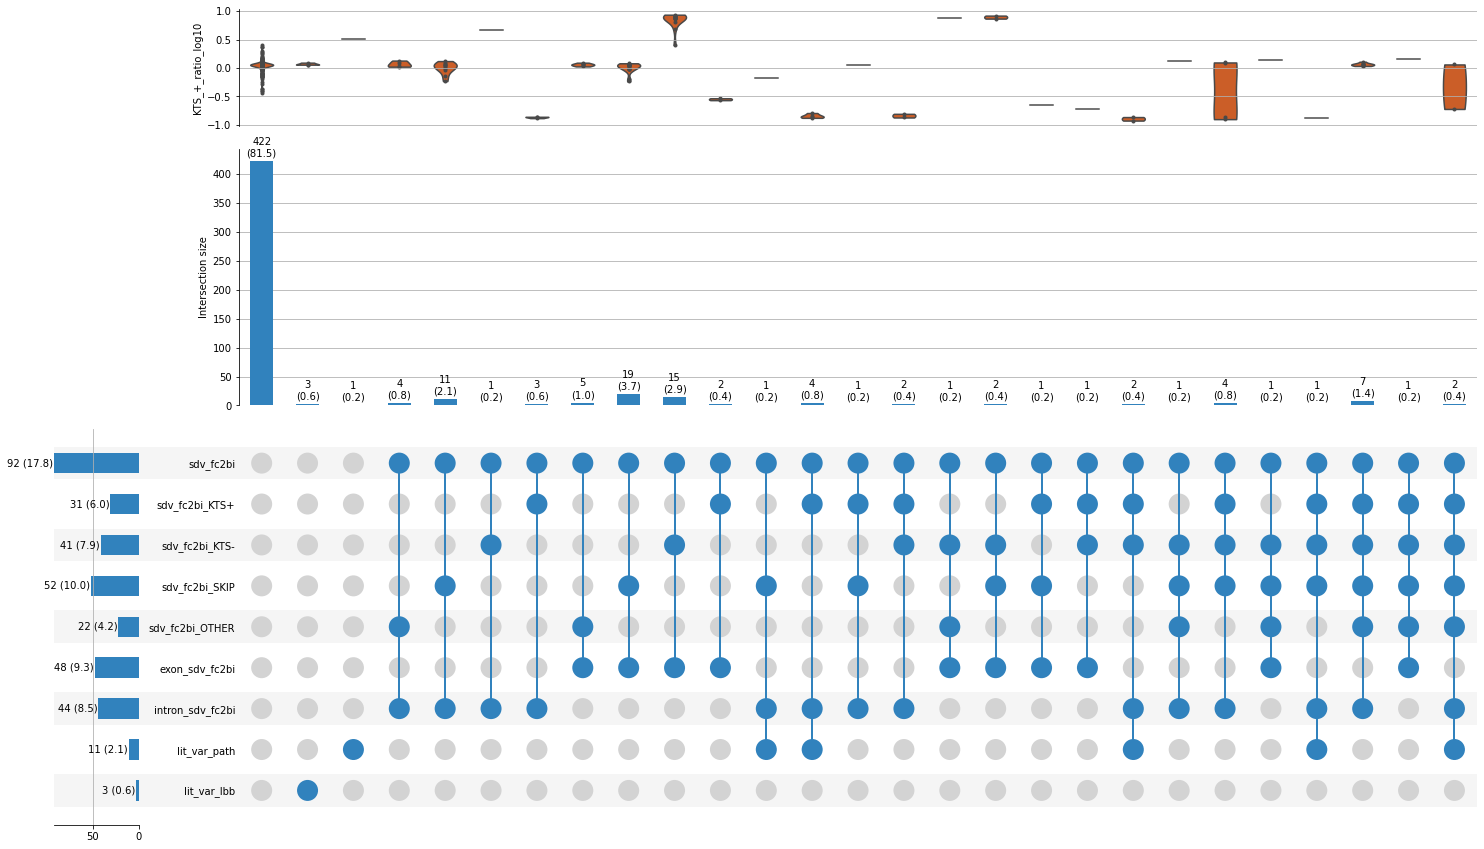

In [113]:
sp.upset_plot( byvartbl_wide_m, 
               [ 'sdv_fc2bi', 'sdv_fc2bi_KTS+', 'sdv_fc2bi_KTS-', 'sdv_fc2bi_SKIP', 'sdv_fc2bi_OTHER', 'exon_sdv_fc2bi', 'intron_sdv_fc2bi', 'lit_var_path', 'lit_var_lbb' ][::-1],
                ( 14, 14 ),
                [ 'KTS_+_ratio_log10' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
              )

In [61]:
byvartbl_wide_m = pp.sdv_by_iso( byvartbl_wide_m,
                                   iso_names,
                                   'zwmean_bs_null_',
                                   ss.norm.ppf( 1 - bonfer ),
                                   'fc_',
                                   3,
                                   out_col_stem = 'sdv_fc3bi_',
                                   bi_directional = True
                                   )

In [62]:
byvartbl_wide_m

,pos,ref,alt,hgvs_pos,hg19_pos,ref_c,alt_c,chrom,varlist,exon_num,...,sdv_fc2bi_SKIP,sdv_fc2bi_OTHER,sdv_fc2bi,exon_sdv_fc2bi,intron_sdv_fc2bi,lit_var_sdv_fc2bi,sdv_fc3bi_KTS+,sdv_fc3bi_KTS-,sdv_fc3bi_SKIP,sdv_fc3bi_OTHER
0,1227,G,A,c.1355-40,32413650,C,T,11,jkp815:1227:C:T,9,...,False,False,False,False,False,False,False,False,False,False
1,1227,G,C,c.1355-40,32413650,C,G,11,jkp815:1227:C:G,9,...,False,False,False,False,False,False,False,False,False,False
2,1227,G,T,c.1355-40,32413650,C,A,11,jkp815:1227:C:A,9,...,False,False,False,False,False,False,False,False,False,False
3,1228,T,A,c.1355-39,32413649,A,T,11,jkp815:1228:A:T,9,...,False,False,False,False,False,False,False,False,False,False
4,1228,T,C,c.1355-39,32413649,A,G,11,jkp815:1228:A:G,9,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,c.1447+39,32413479,T,C,11,jkp815:1398:T:C,9,...,False,False,False,False,False,False,False,False,False,False
514,1398,A,T,c.1447+39,32413479,T,A,11,jkp815:1398:T:A,9,...,False,False,False,False,False,False,False,False,False,False
515,1399,A,C,c.1447+40,32413478,T,G,11,jkp815:1399:T:G,9,...,False,False,False,False,False,False,False,False,False,False
516,1399,A,G,c.1447+40,32413478,T,C,11,jkp815:1399:T:C,9,...,False,False,False,False,False,False,False,False,False,False


In [63]:
byvartbl_wide_m[ 'sdv_fc3bi' ] = byvartbl_wide_m[ [ 'sdv_fc3bi_' + iso for iso in iso_names ] ].any( axis = 'columns' )

In [64]:
byvartbl_wide_m[ 'exon_sdv_fc3bi' ] = ( byvartbl_wide_m.pos >= 1267 ) & ( byvartbl_wide_m.pos <= 1359 ) & ( byvartbl_wide_m[ 'sdv_fc3bi' ] )
byvartbl_wide_m[ 'intron_sdv_fc3bi' ] = ( ( byvartbl_wide_m.pos < 1267 ) | ( byvartbl_wide_m.pos > 1359 ) ) & ( byvartbl_wide_m[ 'sdv_fc3bi' ] )

In [65]:
byvartbl_wide_m[ 'lit_var_sdv_fc3bi' ] = ( byvartbl_wide_m.lit_var ) & ( byvartbl_wide_m[ 'sdv_fc3bi' ] )

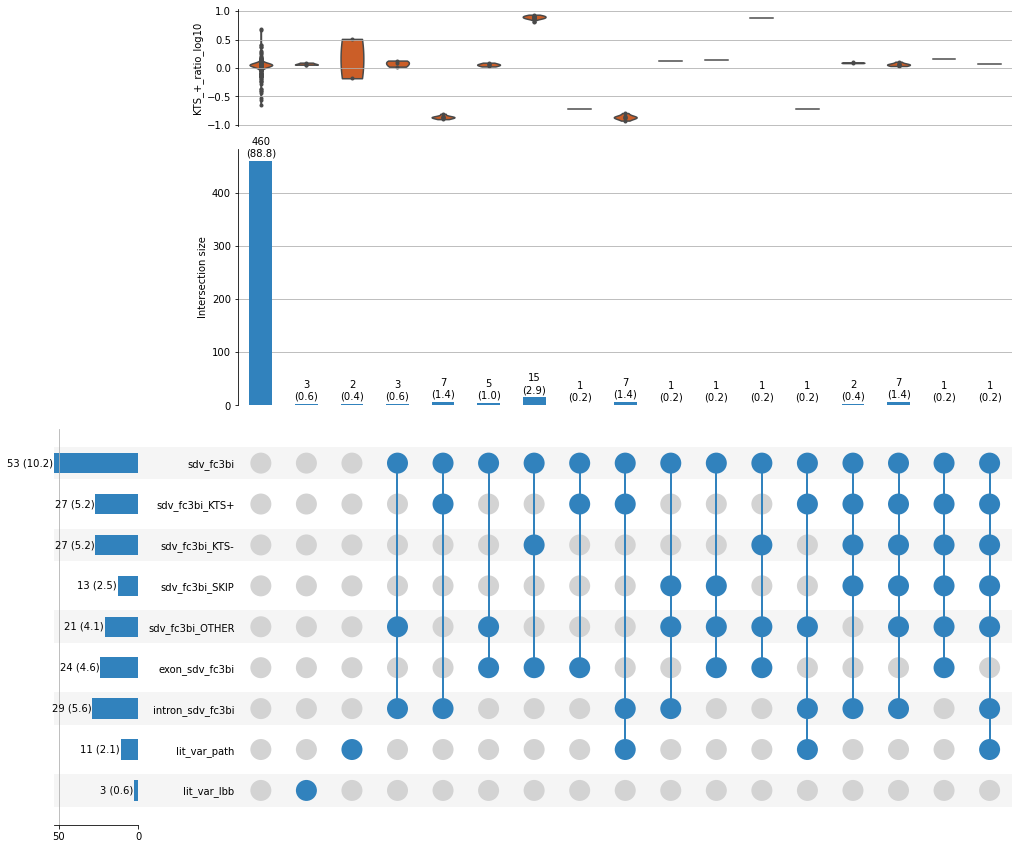

In [114]:
sp.upset_plot( byvartbl_wide_m, 
               [ 'sdv_fc3bi', 'sdv_fc3bi_KTS+', 'sdv_fc3bi_KTS-', 'sdv_fc3bi_SKIP', 'sdv_fc3bi_OTHER', 'exon_sdv_fc3bi', 'intron_sdv_fc3bi', 'lit_var_path', 'lit_var_lbb' ][::-1],
                ( 14, 14 ),
                [ 'KTS_+_ratio_log10' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
              )

In [67]:
byvartbl_wide_m = pp.sdv_by_iso( byvartbl_wide_m,
                                   iso_names,
                                   'zwmean_bs_null_',
                                   ss.norm.ppf( 1 - bonfer ),
                                   'fc_',
                                   3,
                                   out_col_stem = 'sdv_fc3bi_d5PSI_',
                                   chg_null_col_stem = 'wmean_bs_null_',
                                   chg_meas_col_stem = 'wmean_',
                                   chg_thresh = .05,
                                   bi_directional = True
                                   )

In [68]:
byvartbl_wide_m

,pos,ref,alt,hgvs_pos,hg19_pos,ref_c,alt_c,chrom,varlist,exon_num,...,sdv_fc3bi_SKIP,sdv_fc3bi_OTHER,sdv_fc3bi,exon_sdv_fc3bi,intron_sdv_fc3bi,lit_var_sdv_fc3bi,sdv_fc3bi_d5PSI_KTS+,sdv_fc3bi_d5PSI_KTS-,sdv_fc3bi_d5PSI_SKIP,sdv_fc3bi_d5PSI_OTHER
0,1227,G,A,c.1355-40,32413650,C,T,11,jkp815:1227:C:T,9,...,False,False,False,False,False,False,False,False,False,False
1,1227,G,C,c.1355-40,32413650,C,G,11,jkp815:1227:C:G,9,...,False,False,False,False,False,False,False,False,False,False
2,1227,G,T,c.1355-40,32413650,C,A,11,jkp815:1227:C:A,9,...,False,False,False,False,False,False,False,False,False,False
3,1228,T,A,c.1355-39,32413649,A,T,11,jkp815:1228:A:T,9,...,False,False,False,False,False,False,False,False,False,False
4,1228,T,C,c.1355-39,32413649,A,G,11,jkp815:1228:A:G,9,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,c.1447+39,32413479,T,C,11,jkp815:1398:T:C,9,...,False,False,False,False,False,False,False,False,False,False
514,1398,A,T,c.1447+39,32413479,T,A,11,jkp815:1398:T:A,9,...,False,False,False,False,False,False,False,False,False,False
515,1399,A,C,c.1447+40,32413478,T,G,11,jkp815:1399:T:G,9,...,False,False,False,False,False,False,False,False,False,False
516,1399,A,G,c.1447+40,32413478,T,C,11,jkp815:1399:T:C,9,...,False,False,False,False,False,False,False,False,False,False


In [69]:
byvartbl_wide_m[ 'sdv_fc3bi_d5PSI' ] = byvartbl_wide_m[ [ 'sdv_fc3bi_d5PSI_' + iso for iso in iso_names ] ].any( axis = 'columns' )

In [70]:
byvartbl_wide_m[ 'exon_sdv_fc3bi_d5PSI' ] = ( byvartbl_wide_m.pos >= 1267 ) & ( byvartbl_wide_m.pos <= 1359 ) & ( byvartbl_wide_m[ 'sdv_fc3bi_d5PSI' ] )
byvartbl_wide_m[ 'intron_sdv_fc3bi_d5PSI' ] = ( ( byvartbl_wide_m.pos < 1267 ) | ( byvartbl_wide_m.pos > 1359 ) ) & ( byvartbl_wide_m[ 'sdv_fc3bi_d5PSI' ] )

In [71]:
byvartbl_wide_m[ 'lit_var_sdv_fc3bi_d5PSI' ] = ( byvartbl_wide_m.lit_var ) & ( byvartbl_wide_m[ 'sdv_fc3bi_d5PSI' ] )

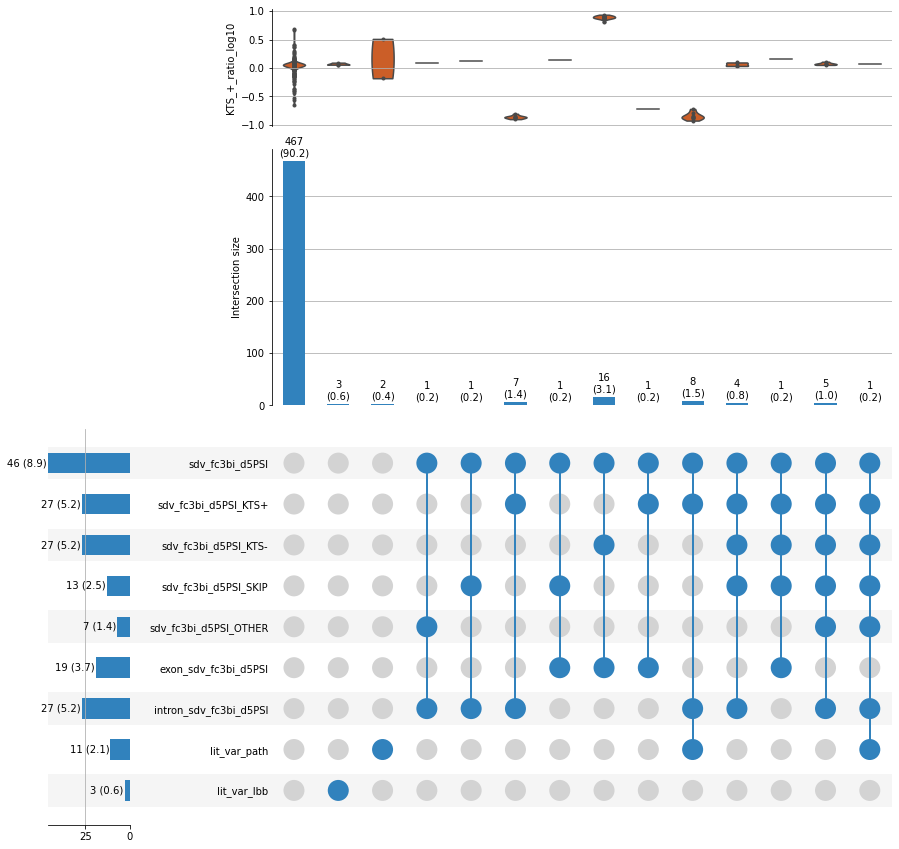

In [115]:
sp.upset_plot( byvartbl_wide_m, 
               [ 'sdv_fc3bi_d5PSI', 'sdv_fc3bi_d5PSI_KTS+', 'sdv_fc3bi_d5PSI_KTS-', 'sdv_fc3bi_d5PSI_SKIP', 'sdv_fc3bi_d5PSI_OTHER', 'exon_sdv_fc3bi_d5PSI', 'intron_sdv_fc3bi_d5PSI', 'lit_var_path', 'lit_var_lbb' ][::-1],
                ( 14, 14 ),
                [ 'KTS_+_ratio_log10' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
              )

In [116]:
byvartbl_wide_m = pp.sdv_by_iso( byvartbl_wide_m,
                                   iso_names,
                                   'zwmean_bs_null_',
                                   ss.norm.ppf( 1 - bonfer ),
                                   'fc_',
                                   2,
                                   out_col_stem = 'sdv_fc2bi_d5PSI_',
                                   chg_null_col_stem = 'wmean_bs_null_',
                                   chg_meas_col_stem = 'wmean_',
                                   chg_thresh = .05,
                                   bi_directional = True
                                   )

In [117]:
byvartbl_wide_m

,pos,ref,alt,hgvs_pos,hg19_pos,ref_c,alt_c,chrom,varlist,exon_num,...,exon_sdv_fc3bi_d5PSI,intron_sdv_fc3bi_d5PSI,lit_var_sdv_fc3bi_d5PSI,lit_var_interp_num,lit_var_path,lit_var_lbb,sdv_fc2bi_d5PSI_KTS+,sdv_fc2bi_d5PSI_KTS-,sdv_fc2bi_d5PSI_SKIP,sdv_fc2bi_d5PSI_OTHER
0,1227,G,A,c.1355-40,32413650,C,T,11,jkp815:1227:C:T,9,...,False,False,False,10,False,False,False,False,False,False
1,1227,G,C,c.1355-40,32413650,C,G,11,jkp815:1227:C:G,9,...,False,False,False,10,False,False,False,False,False,False
2,1227,G,T,c.1355-40,32413650,C,A,11,jkp815:1227:C:A,9,...,False,False,False,10,False,False,False,False,False,False
3,1228,T,A,c.1355-39,32413649,A,T,11,jkp815:1228:A:T,9,...,False,False,False,10,False,False,False,False,False,False
4,1228,T,C,c.1355-39,32413649,A,G,11,jkp815:1228:A:G,9,...,False,False,False,10,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,1398,A,G,c.1447+39,32413479,T,C,11,jkp815:1398:T:C,9,...,False,False,False,10,False,False,False,False,False,False
514,1398,A,T,c.1447+39,32413479,T,A,11,jkp815:1398:T:A,9,...,False,False,False,10,False,False,False,False,False,False
515,1399,A,C,c.1447+40,32413478,T,G,11,jkp815:1399:T:G,9,...,False,False,False,10,False,False,False,False,False,False
516,1399,A,G,c.1447+40,32413478,T,C,11,jkp815:1399:T:C,9,...,False,False,False,10,False,False,False,False,False,False


In [118]:
byvartbl_wide_m[ 'sdv_fc2bi_d5PSI' ] = byvartbl_wide_m[ [ 'sdv_fc2bi_d5PSI_' + iso for iso in iso_names ] ].any( axis = 'columns' )

In [119]:
byvartbl_wide_m[ 'exon_sdv_fc2bi_d5PSI' ] = ( byvartbl_wide_m.pos >= 1267 ) & ( byvartbl_wide_m.pos <= 1359 ) & ( byvartbl_wide_m[ 'sdv_fc2bi_d5PSI' ] )
byvartbl_wide_m[ 'intron_sdv_fc2bi_d5PSI' ] = ( ( byvartbl_wide_m.pos < 1267 ) | ( byvartbl_wide_m.pos > 1359 ) ) & ( byvartbl_wide_m[ 'sdv_fc2bi_d5PSI' ] )

In [120]:
byvartbl_wide_m[ 'lit_var_sdv_fc2bi_d5PSI' ] = ( byvartbl_wide_m.lit_var ) & ( byvartbl_wide_m[ 'sdv_fc2bi_d5PSI' ] )

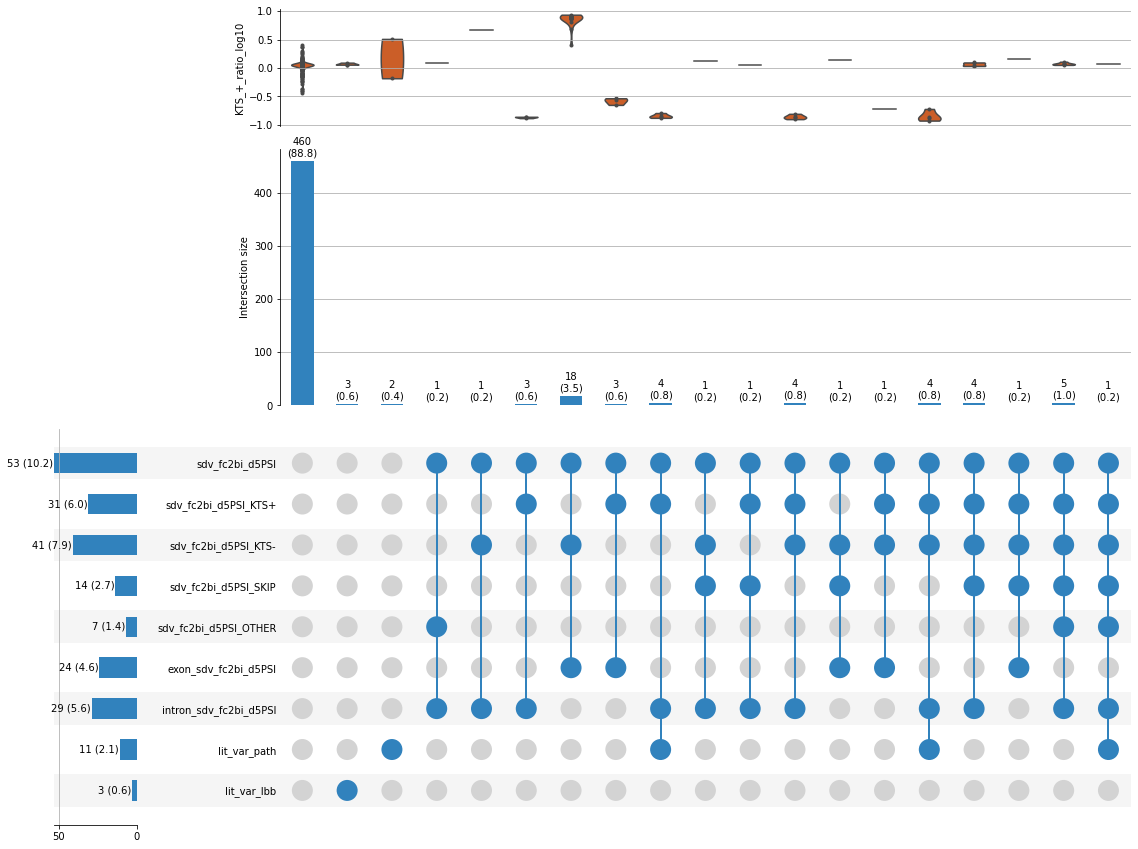

In [121]:
sp.upset_plot( byvartbl_wide_m, 
               [ 'sdv_fc2bi_d5PSI', 'sdv_fc2bi_d5PSI_KTS+', 'sdv_fc2bi_d5PSI_KTS-', 'sdv_fc2bi_d5PSI_SKIP', 'sdv_fc2bi_d5PSI_OTHER', 'exon_sdv_fc2bi_d5PSI', 'intron_sdv_fc2bi_d5PSI', 'lit_var_path', 'lit_var_lbb' ][::-1],
                ( 14, 14 ),
                [ 'KTS_+_ratio_log10' ],
                [ 'violin' ],
                [ light_colors[ 4 ] ],
                show_counts = '%d',
                show_percentages = '%.1f',
                facecolor = light_colors[ 0 ],
                element_size = 60,
               sort_categories_by = None,
              )

In [122]:
byvartbl_sat = pp.saturate_variants( byvartbl_wide_m,
                                     chr11_seq,
                                     'hg19_pos',
                                      'exon_num',
                                      rev_strand = True )[ 9 ]

In [123]:
#plots get messed up without the vector position included
byvartbl_sat[ 'pos' ] = byvartbl_sat.hg19_pos - 32412079 - 2*( byvartbl_sat.hg19_pos - byvartbl_sat.hg19_pos.min() )

In [124]:
byvartbl_sat[ 'hgvs_pos' ] = cds.pos_to_hgvspos( byvartbl_sat.pos,
                                                 ( 1058, 1554 ),
                                                [ (1267, 1359) ],
                                                [ ( 1355, 1447 ), ]
                                                )

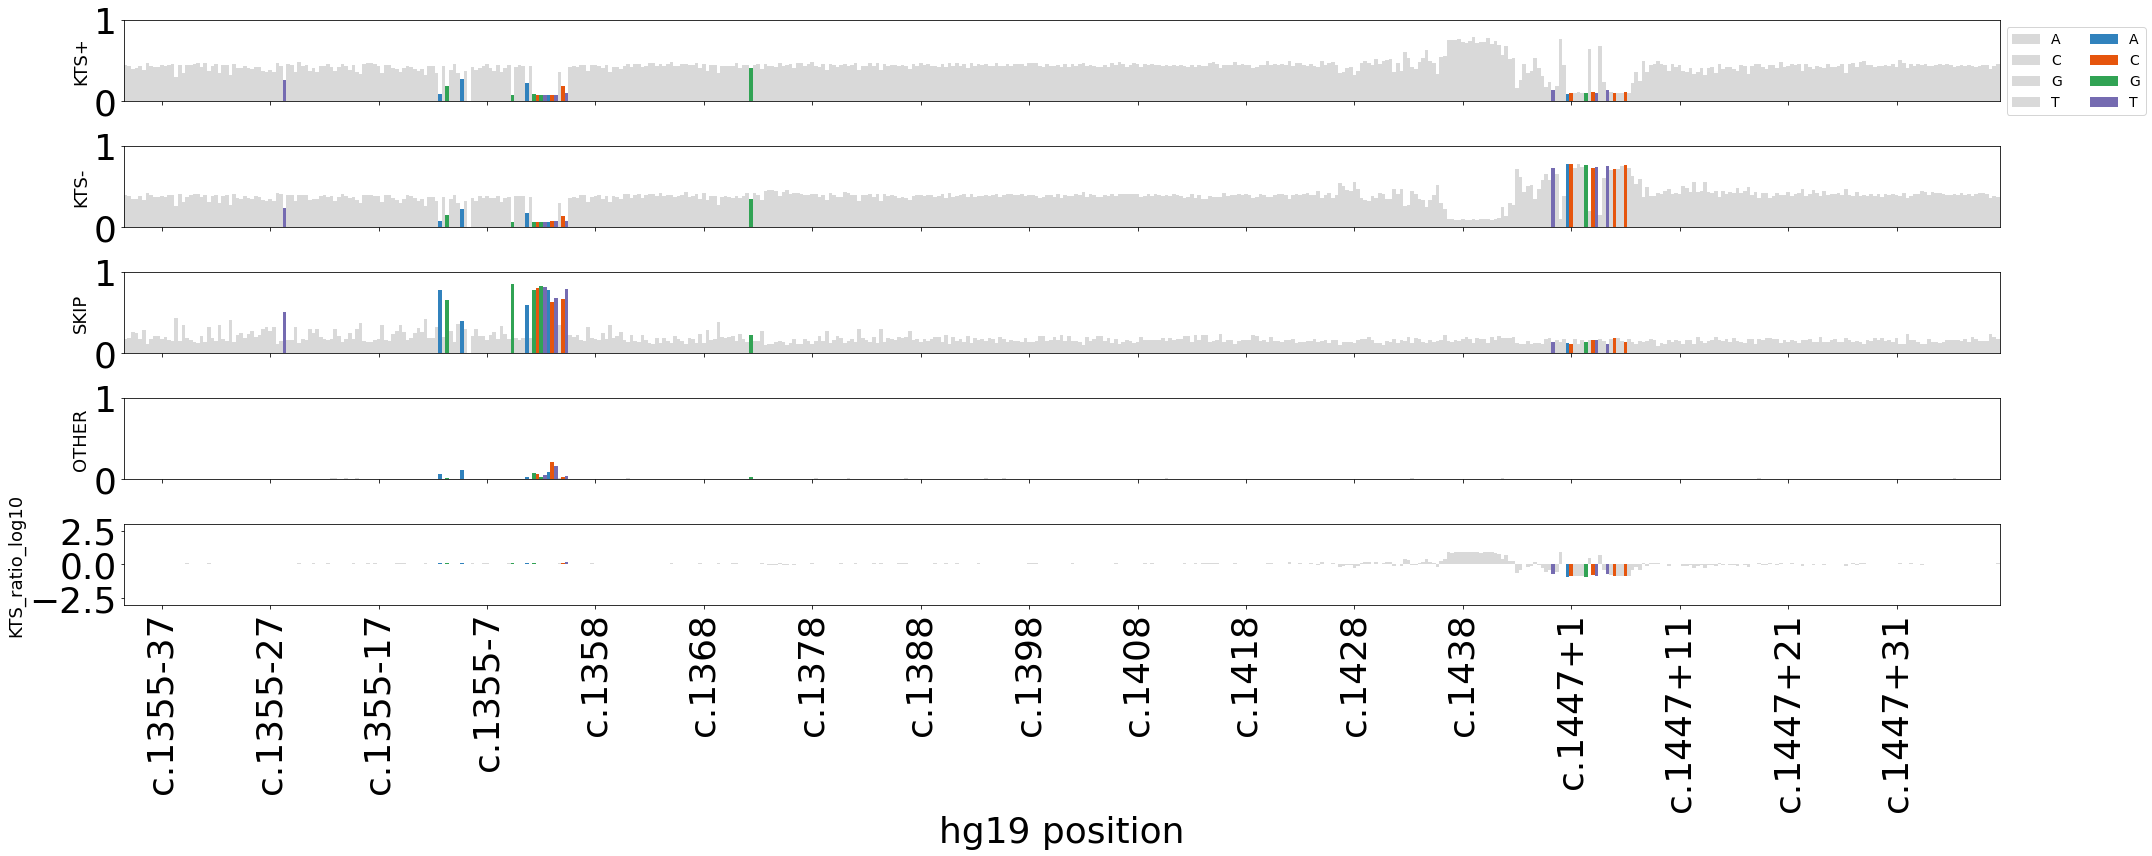

In [76]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 3 ] ) ],
                          darken_bars = [ ( 'sdv_fc2+', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

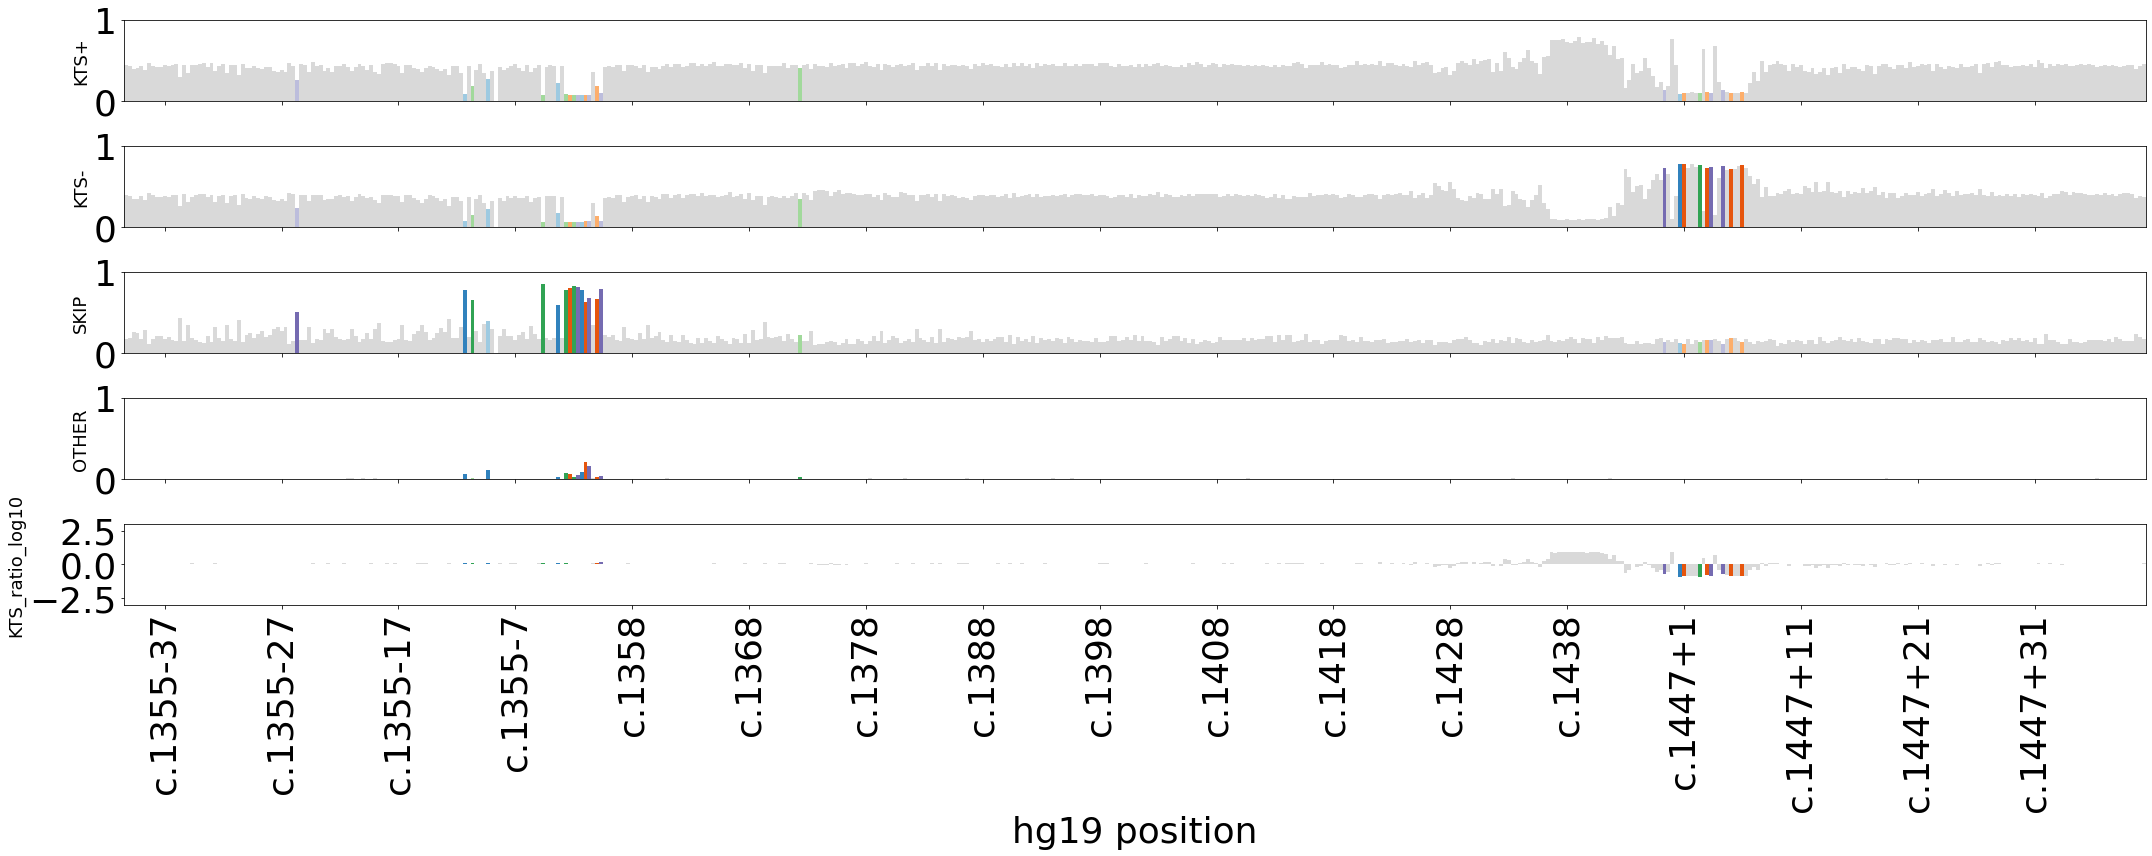

In [78]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv_fc2+', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_fc2+_KTS+', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2+_KTS-', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2+_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2+_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2+' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

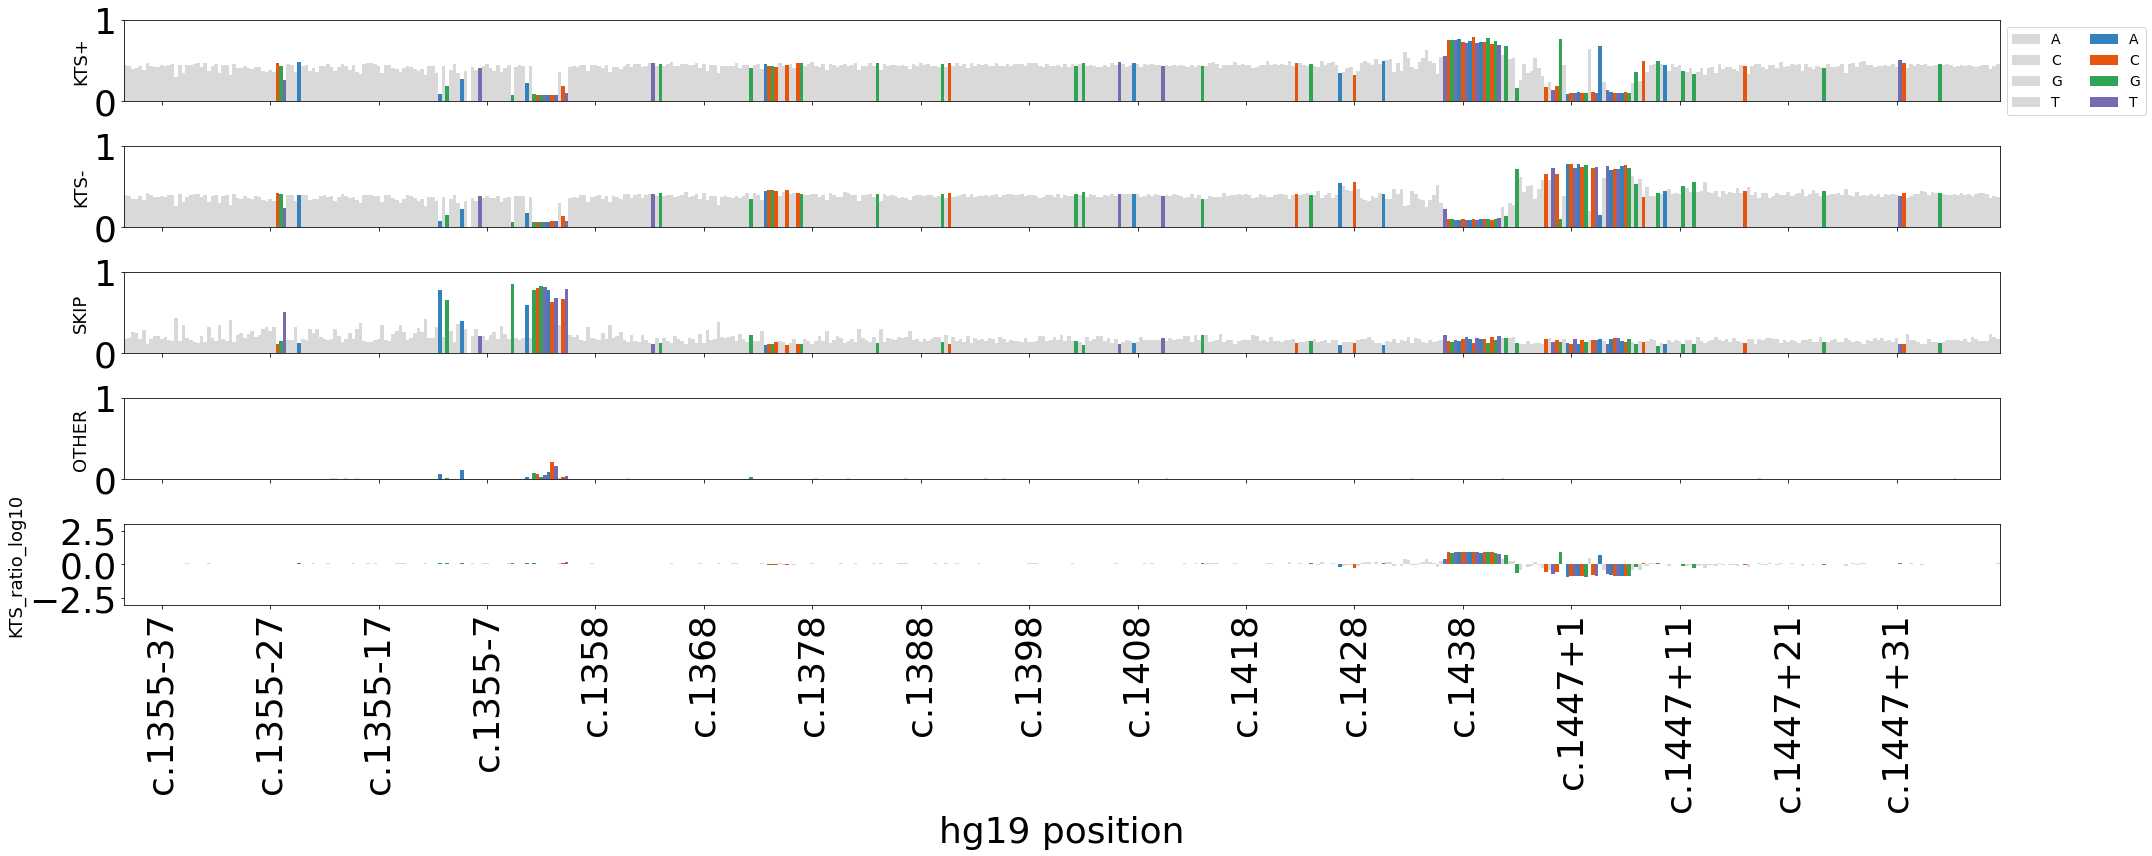

In [79]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 3 ] ) ],
                          darken_bars = [ ( 'sdv_fc2bi', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

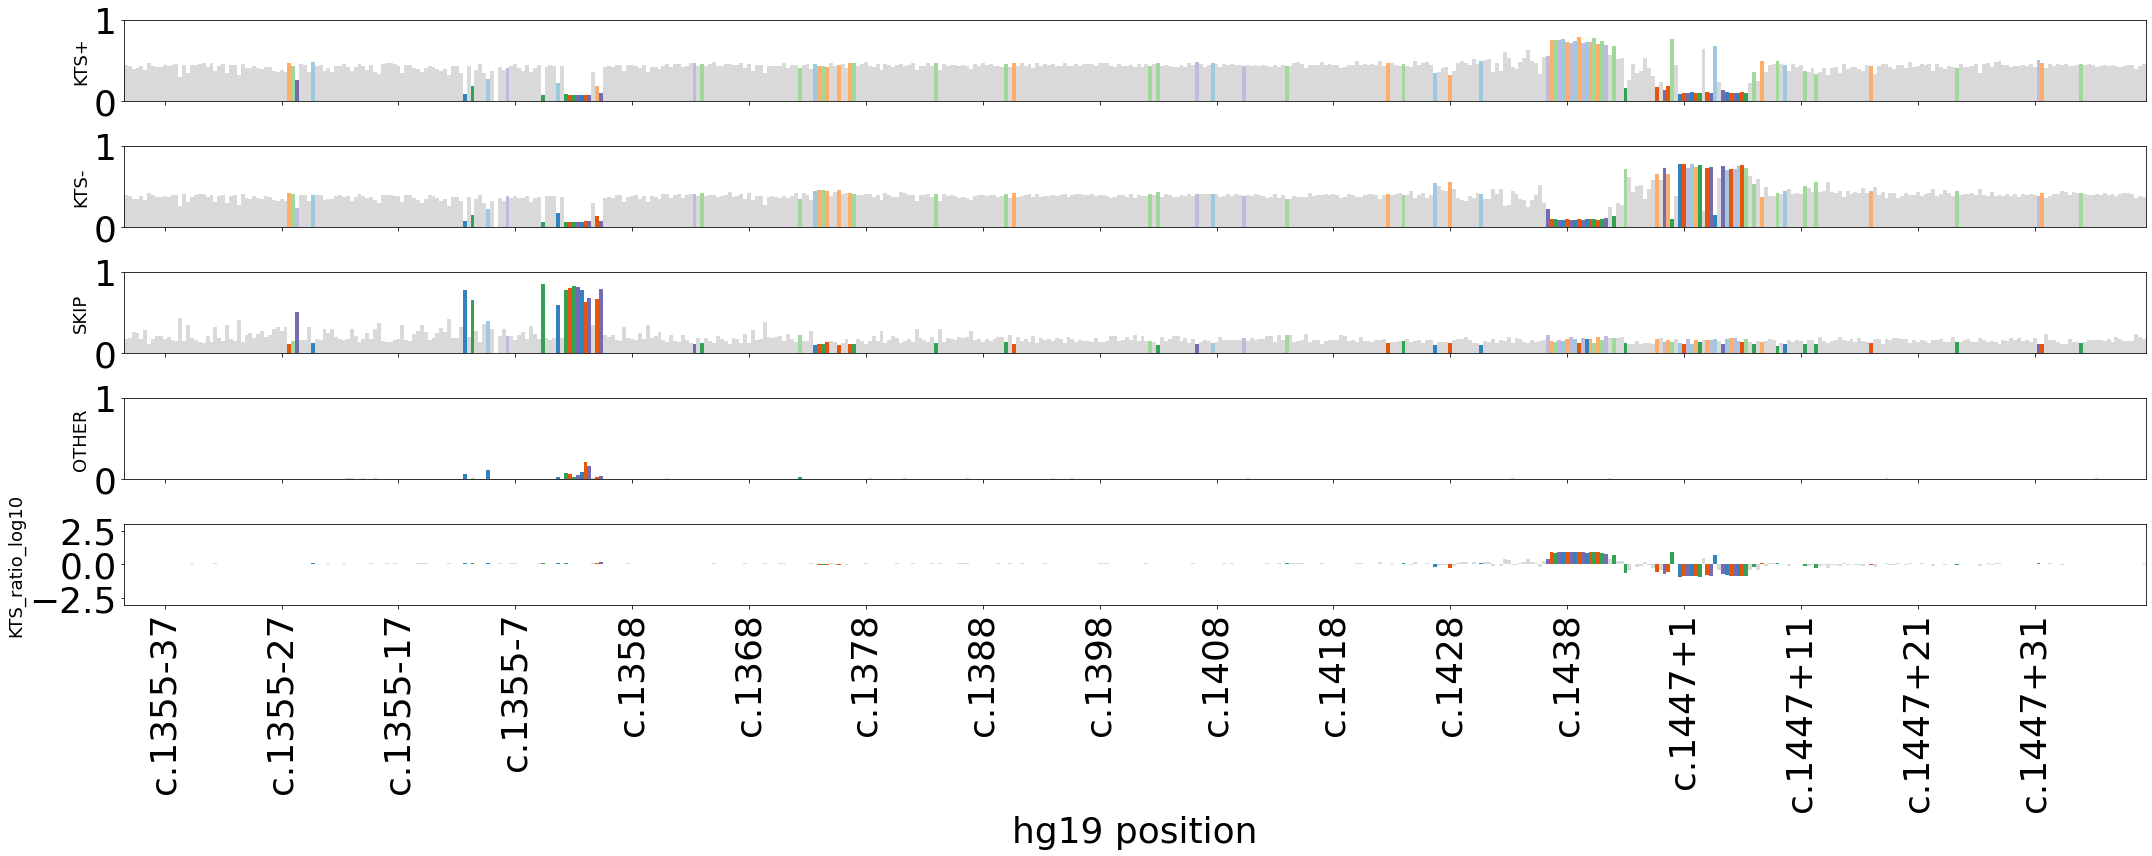

In [80]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv_fc2bi', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_fc2bi_KTS+', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_KTS-', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

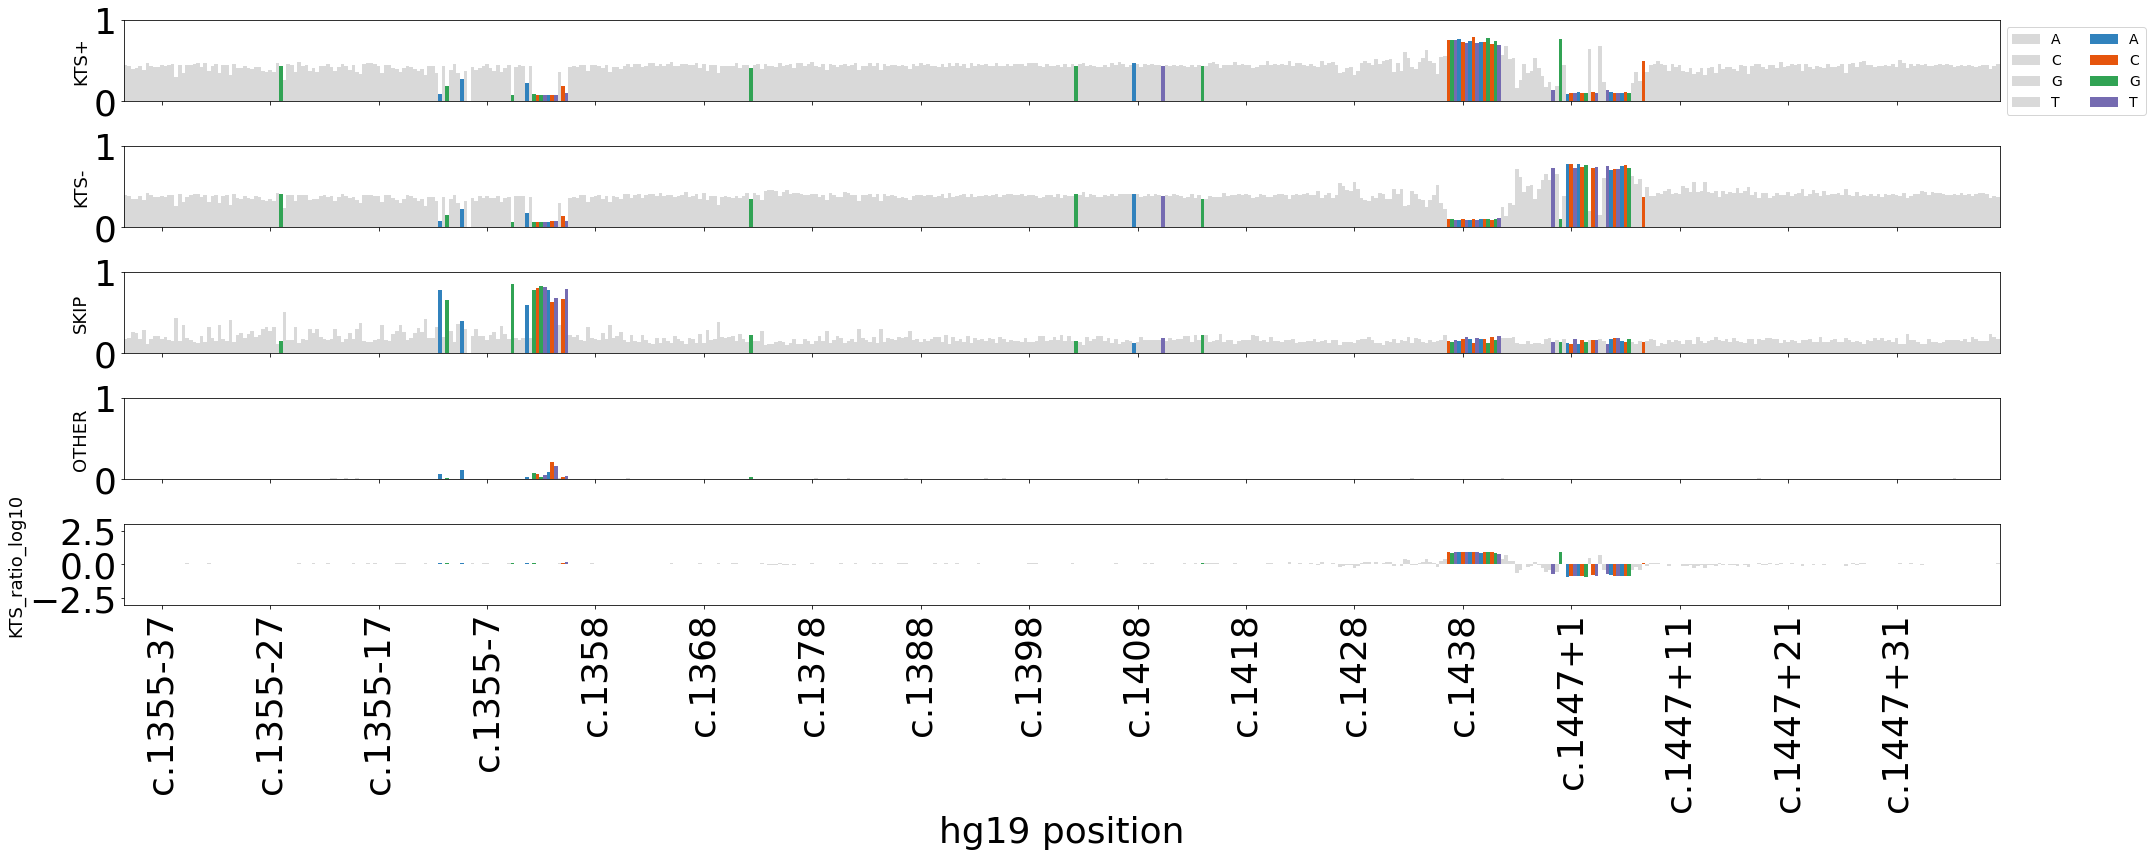

In [81]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 3 ] ) ],
                          darken_bars = [ ( 'sdv_fc3bi', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

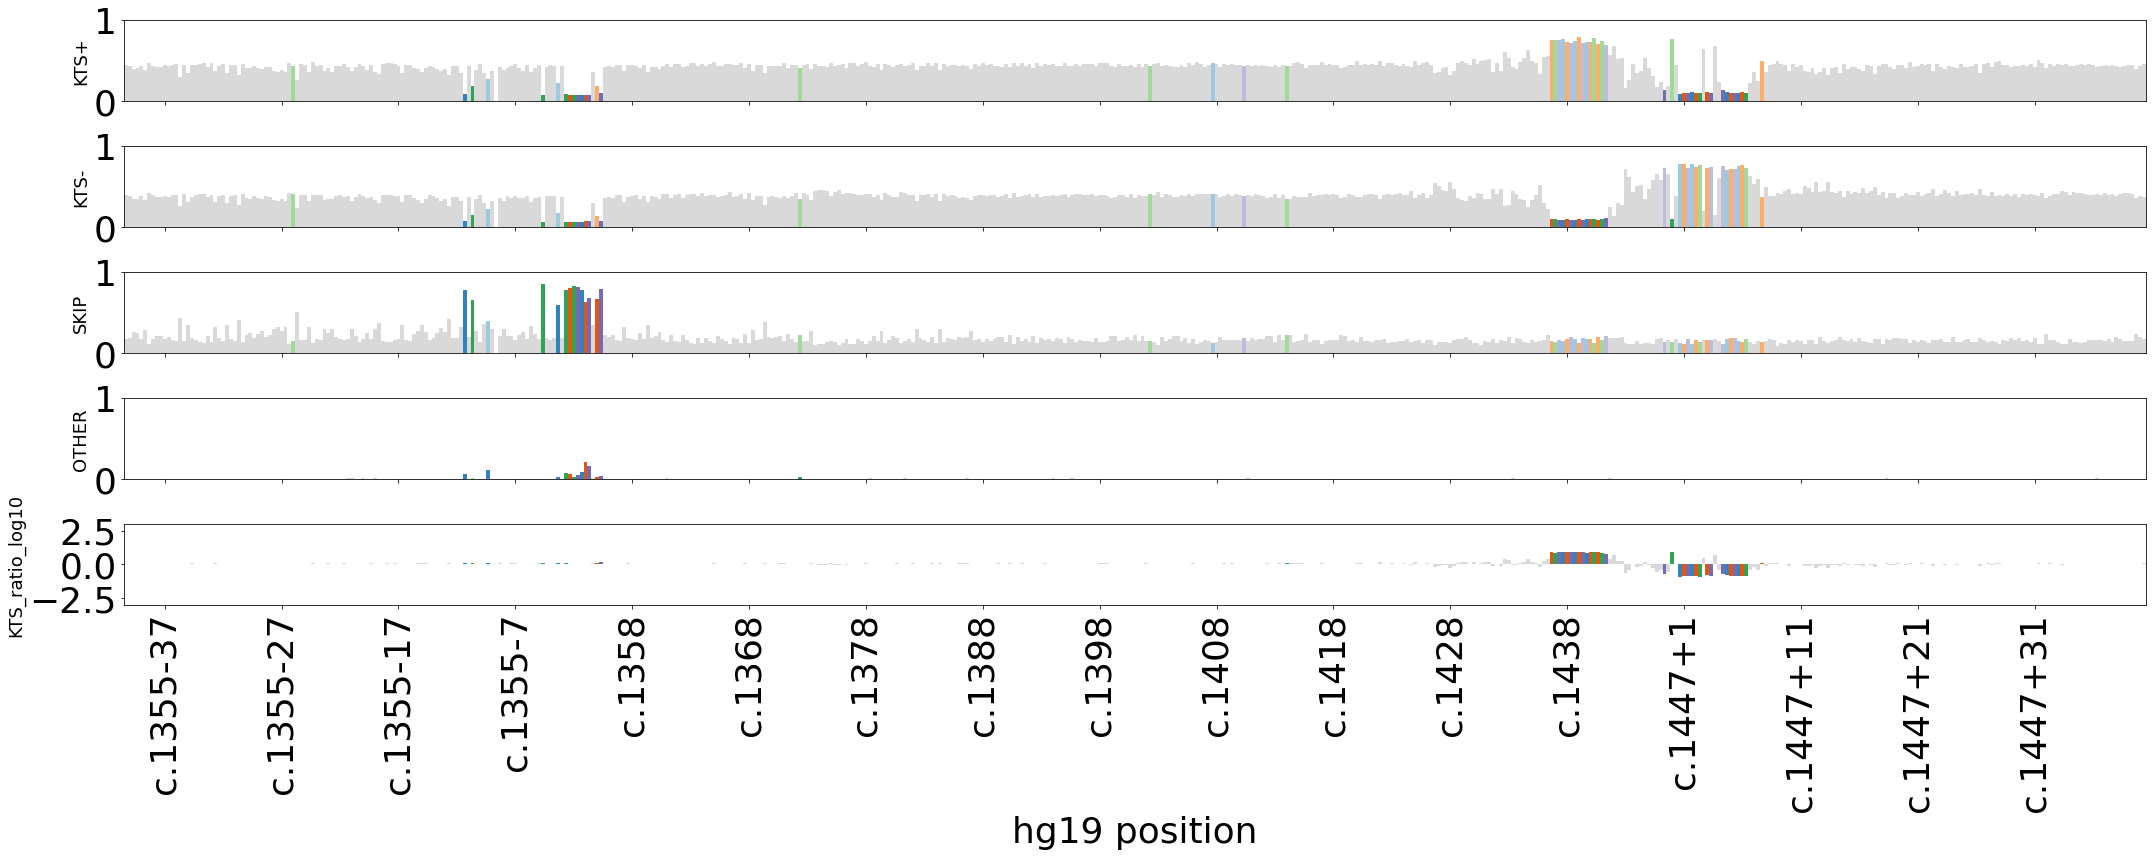

In [82]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv_fc3bi', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_fc3bi_KTS+', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_KTS-', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [86]:
#in frame exon SKIP
len( byvartbl_sat.loc[ ( byvartbl_sat.pos >= 1267 ) & ( byvartbl_sat.pos <= 1359 ) ] ) / 3 / 3

31.0

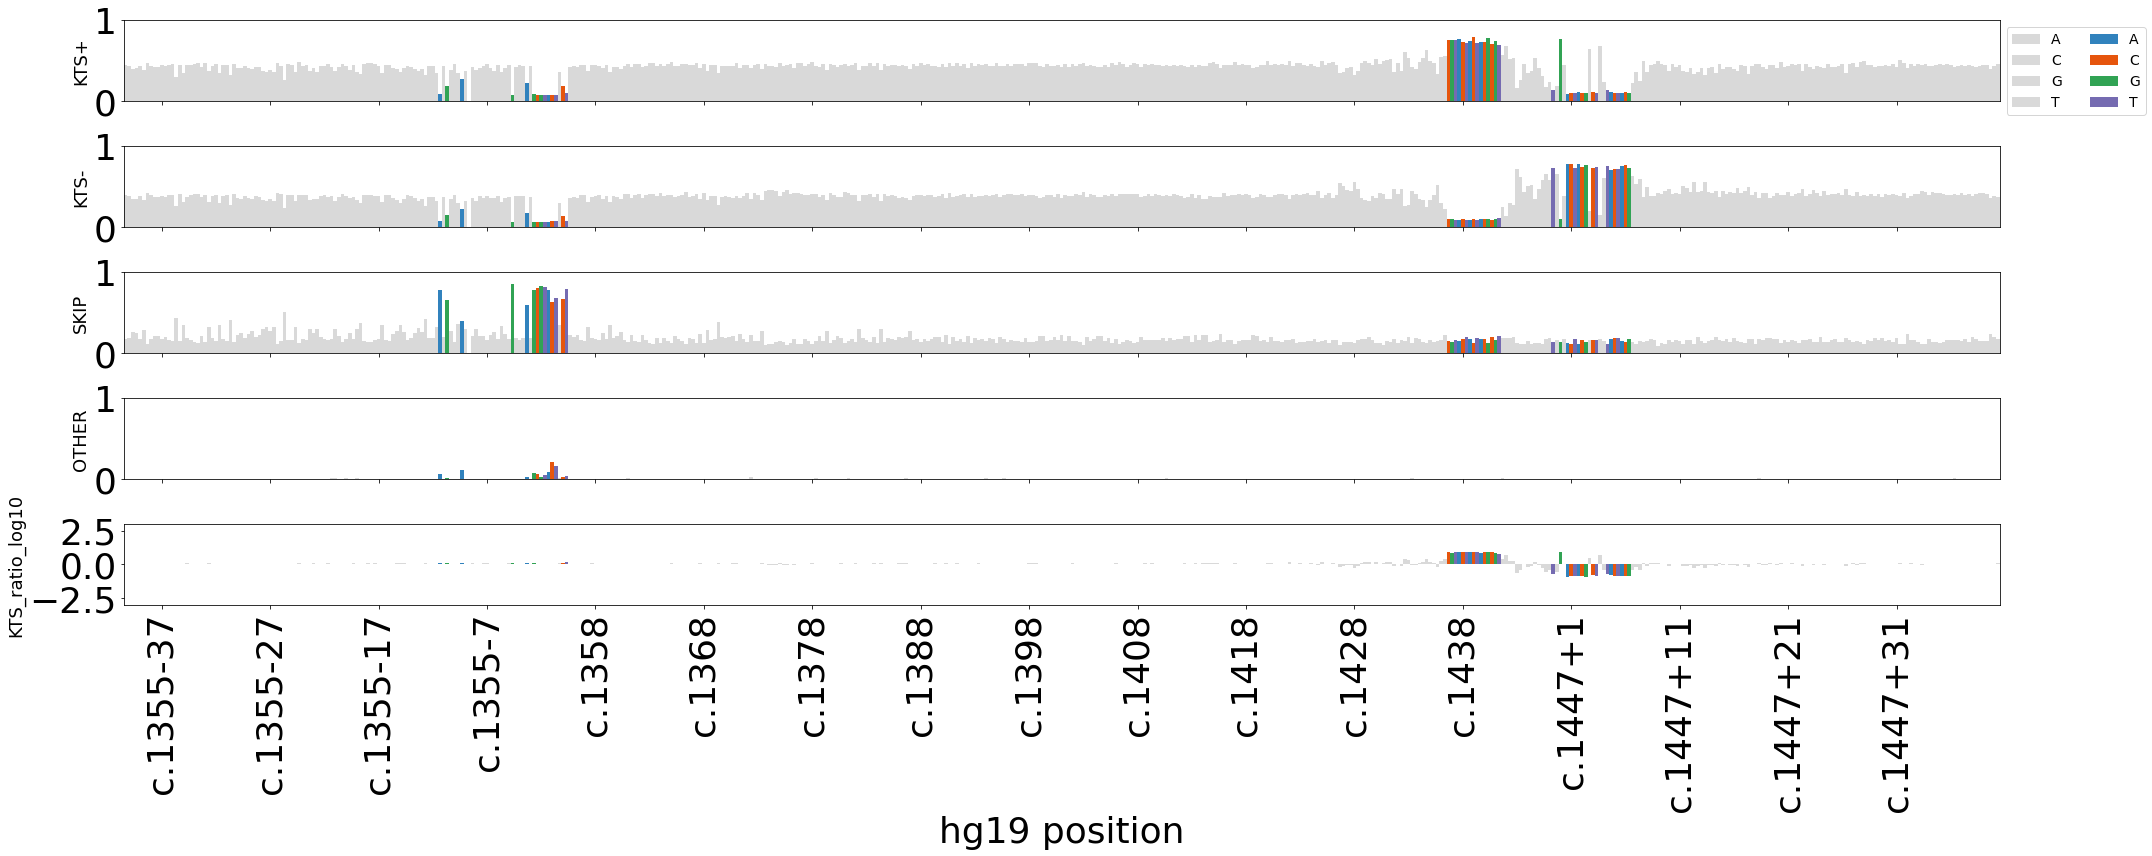

In [87]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 3 ] ) ],
                          darken_bars = [ ( 'sdv_fc3bi_d5PSI', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

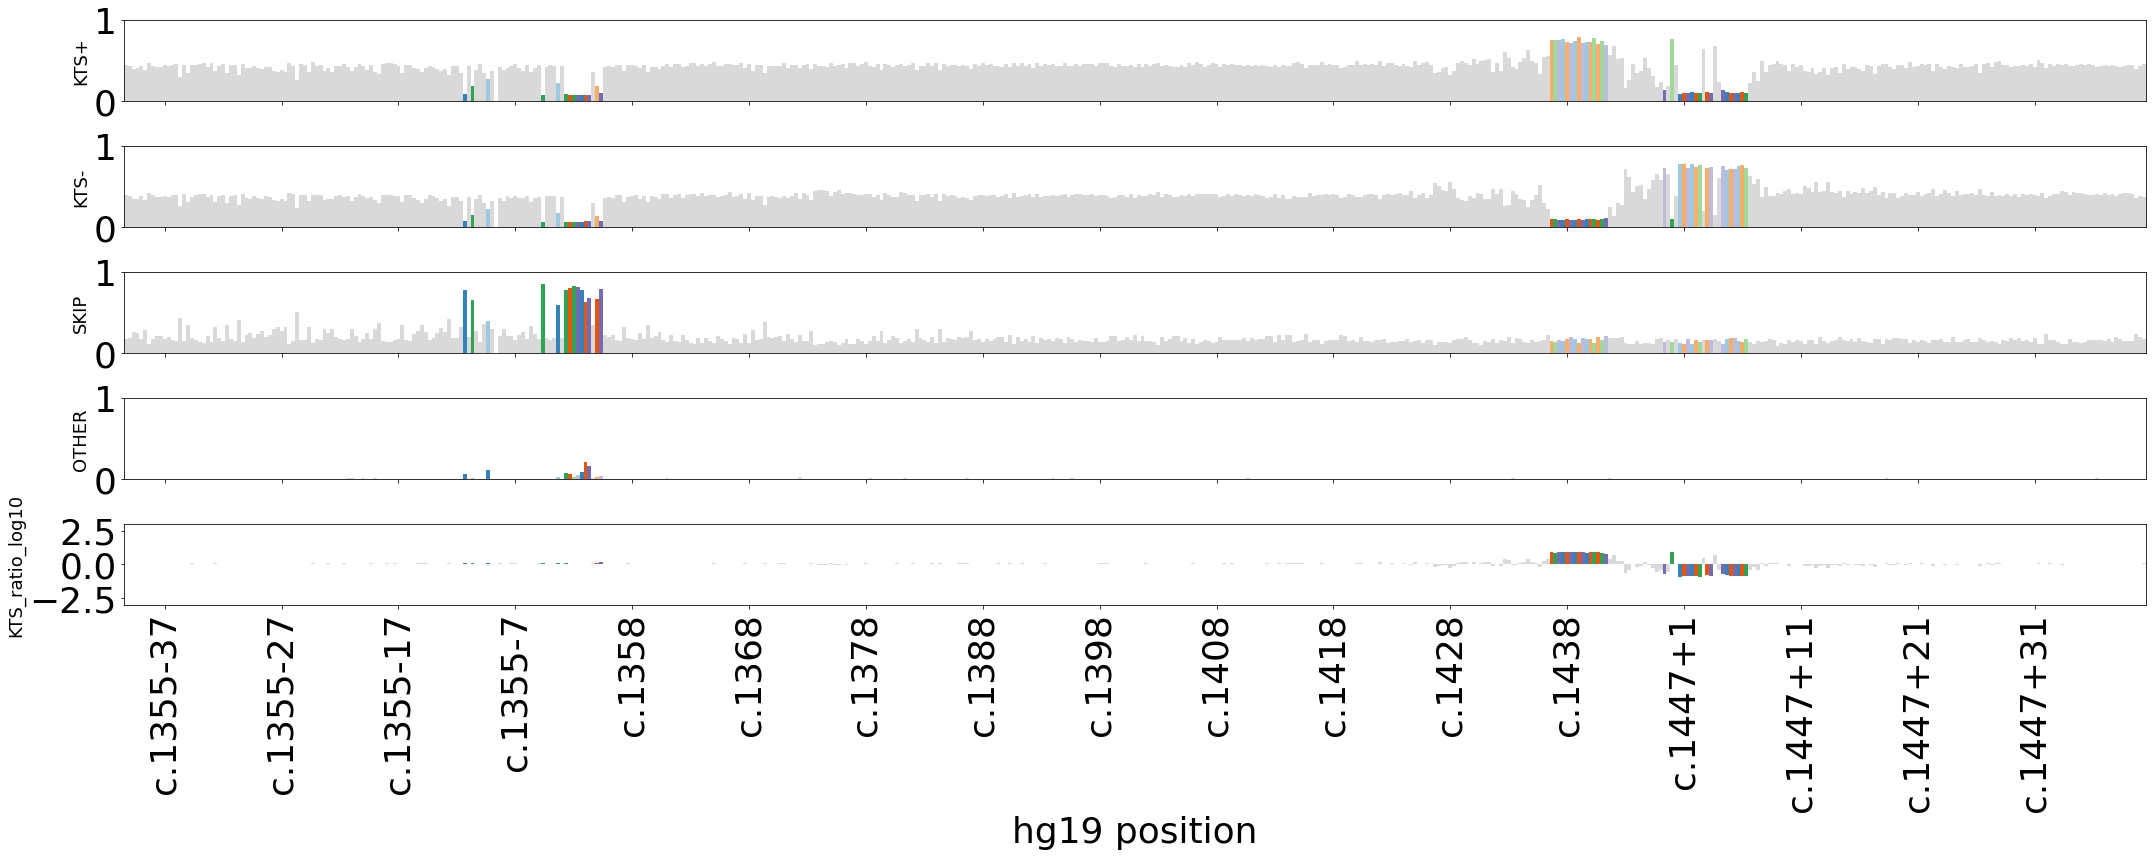

In [88]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv_fc3bi_d5PSI', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_fc3bi_d5PSI_KTS+', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI_KTS-', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

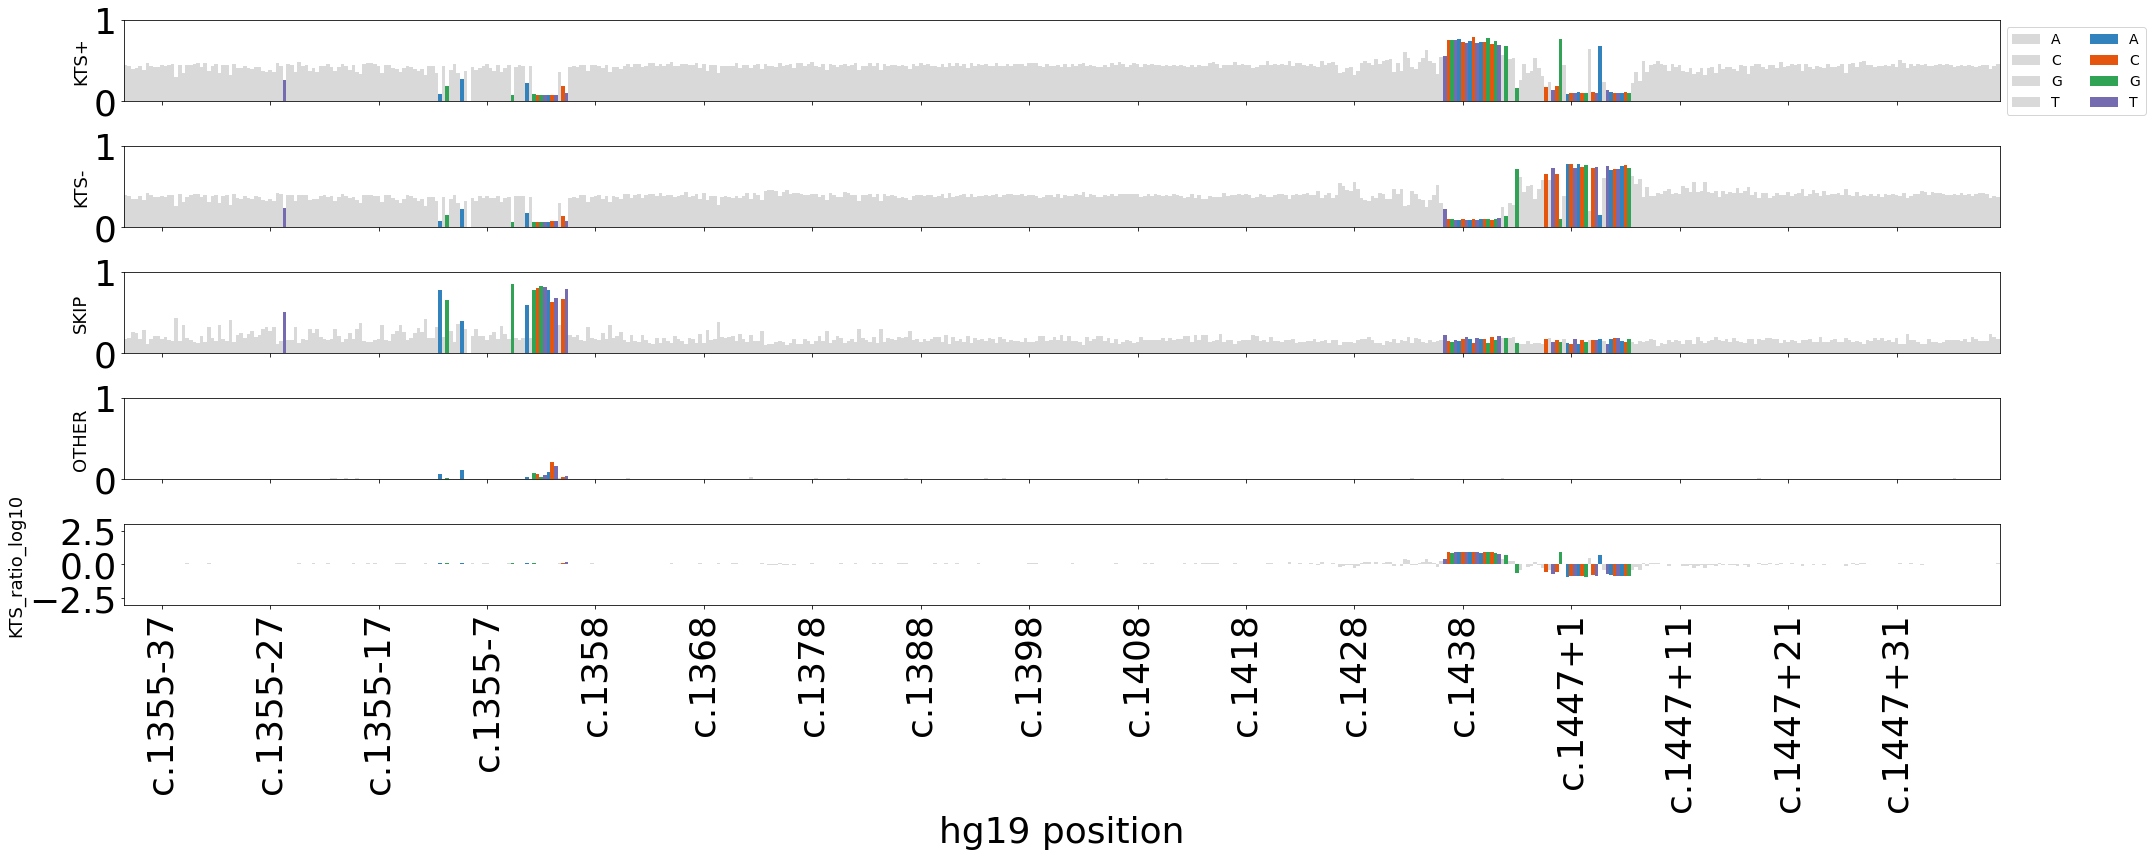

In [125]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv', [ l for idx,l in enumerate( light_colors ) if idx%4 == 3 ] ) ],
                          darken_bars = [ ( 'sdv_fc2bi_d5PSI', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

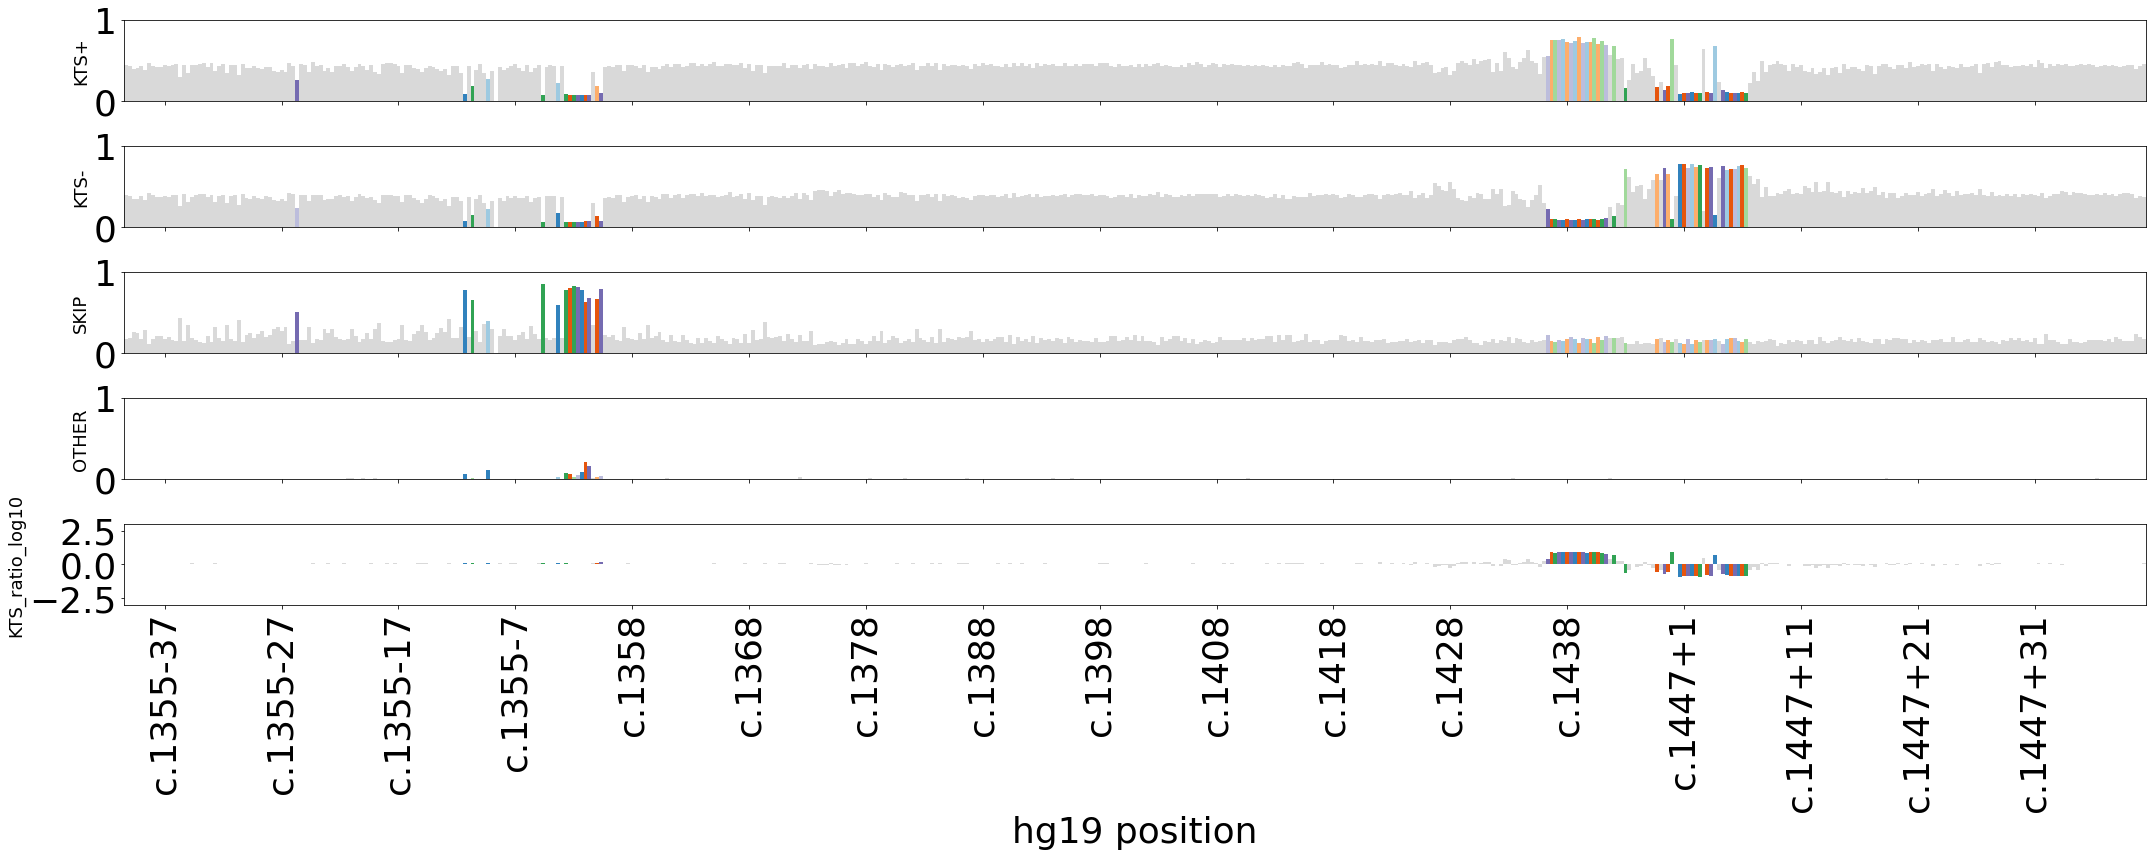

In [127]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv_fc2bi_d5PSI', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_fc2bi_d5PSI_KTS+', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI_KTS-', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

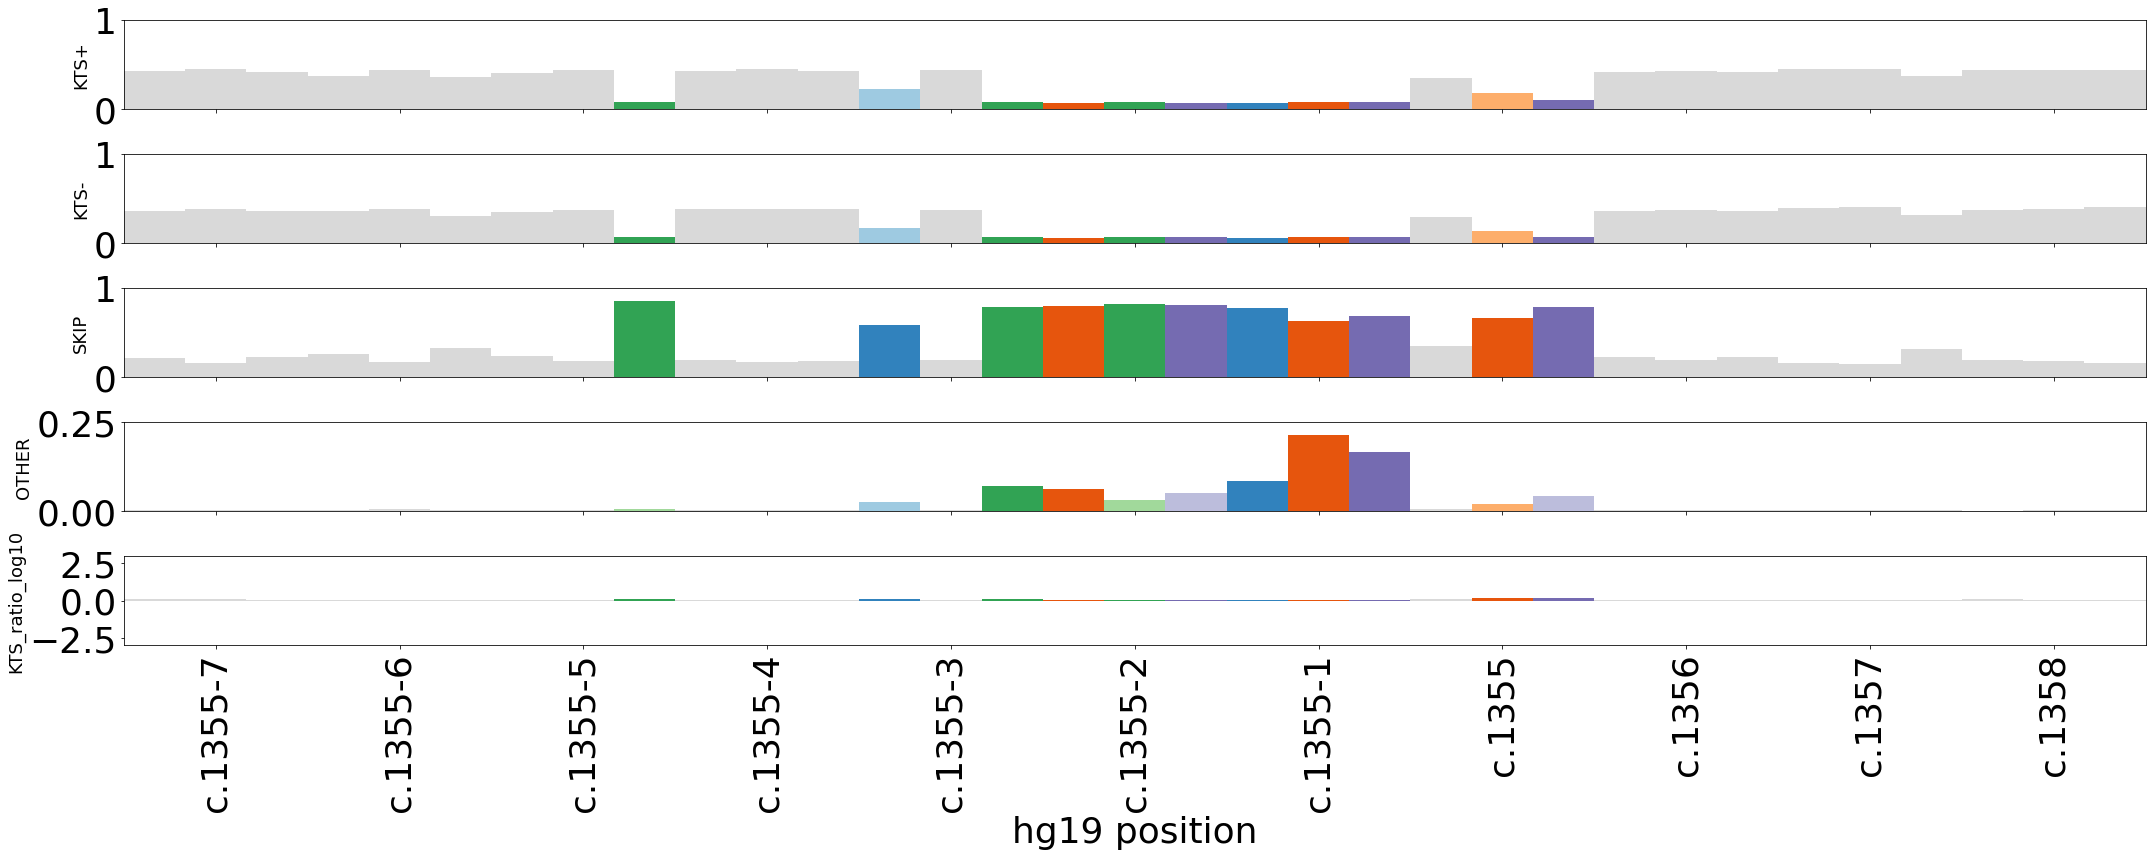

In [130]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1260, 1270 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv_fc3bi_d5PSI', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_fc3bi_d5PSI_KTS+', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI_KTS-', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, .25 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

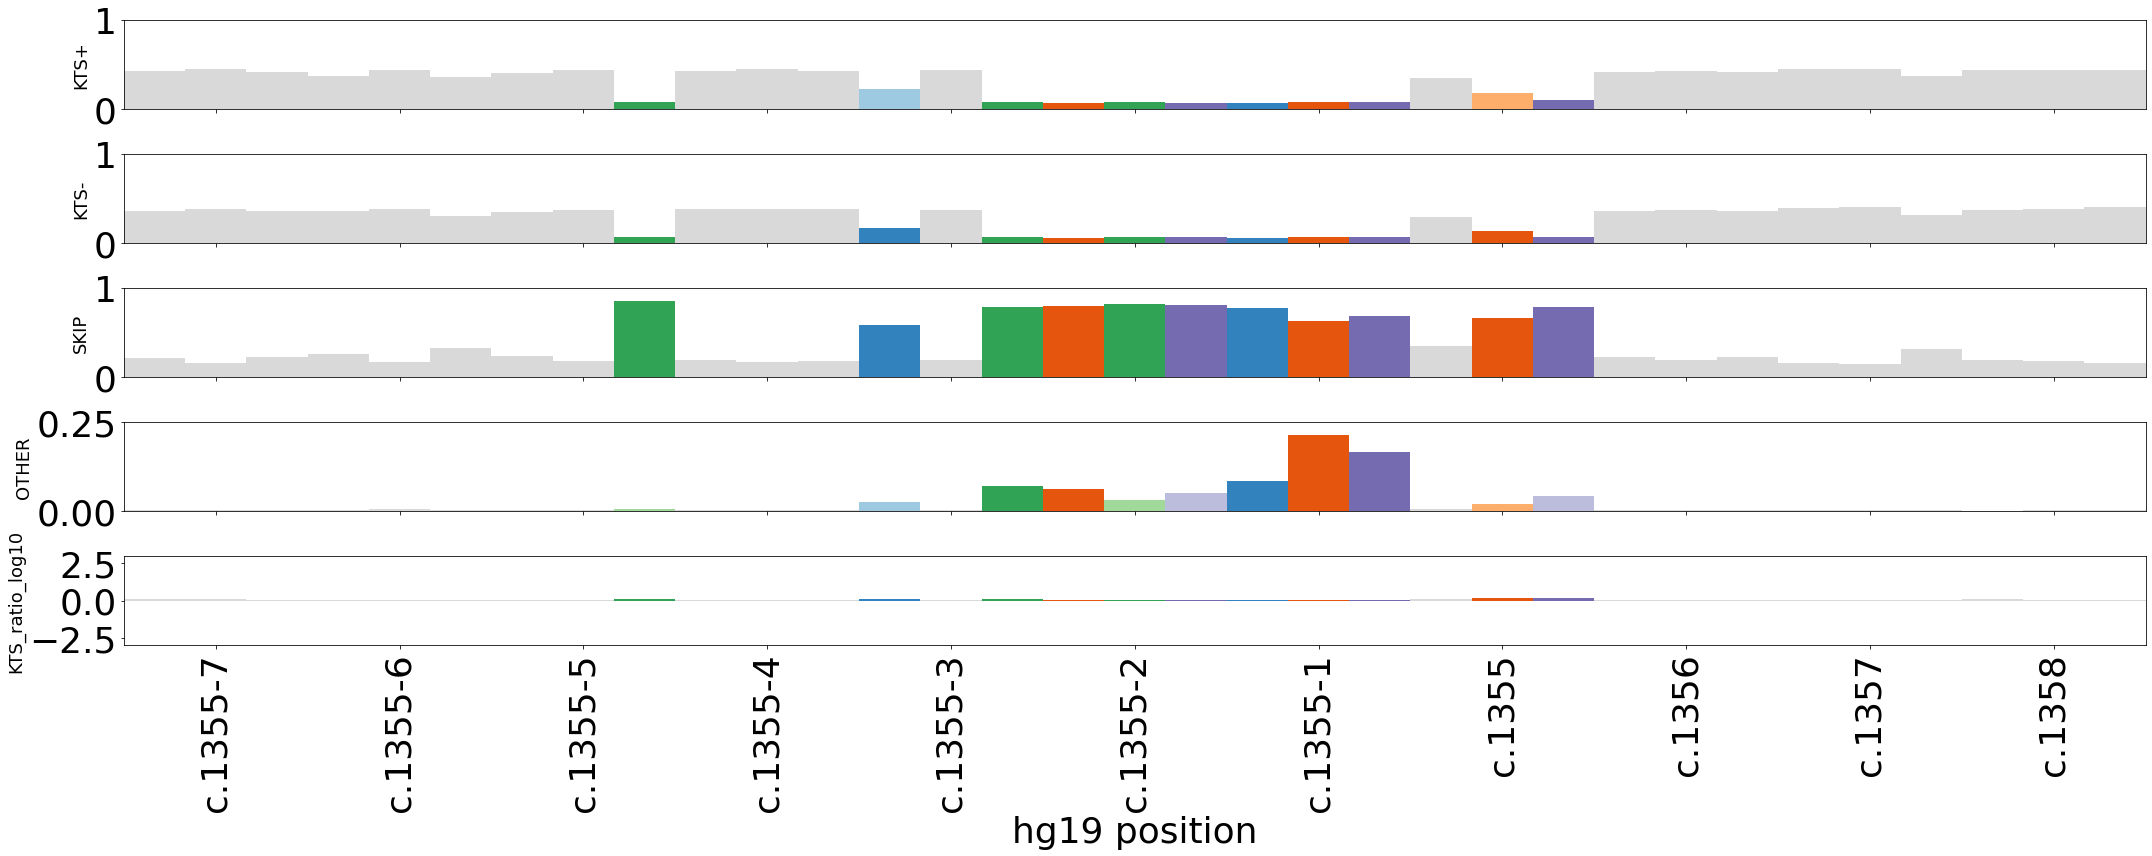

In [132]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1260, 1270 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv_fc2bi_d5PSI', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_fc2bi_d5PSI_KTS+', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI_KTS-', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, .25 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

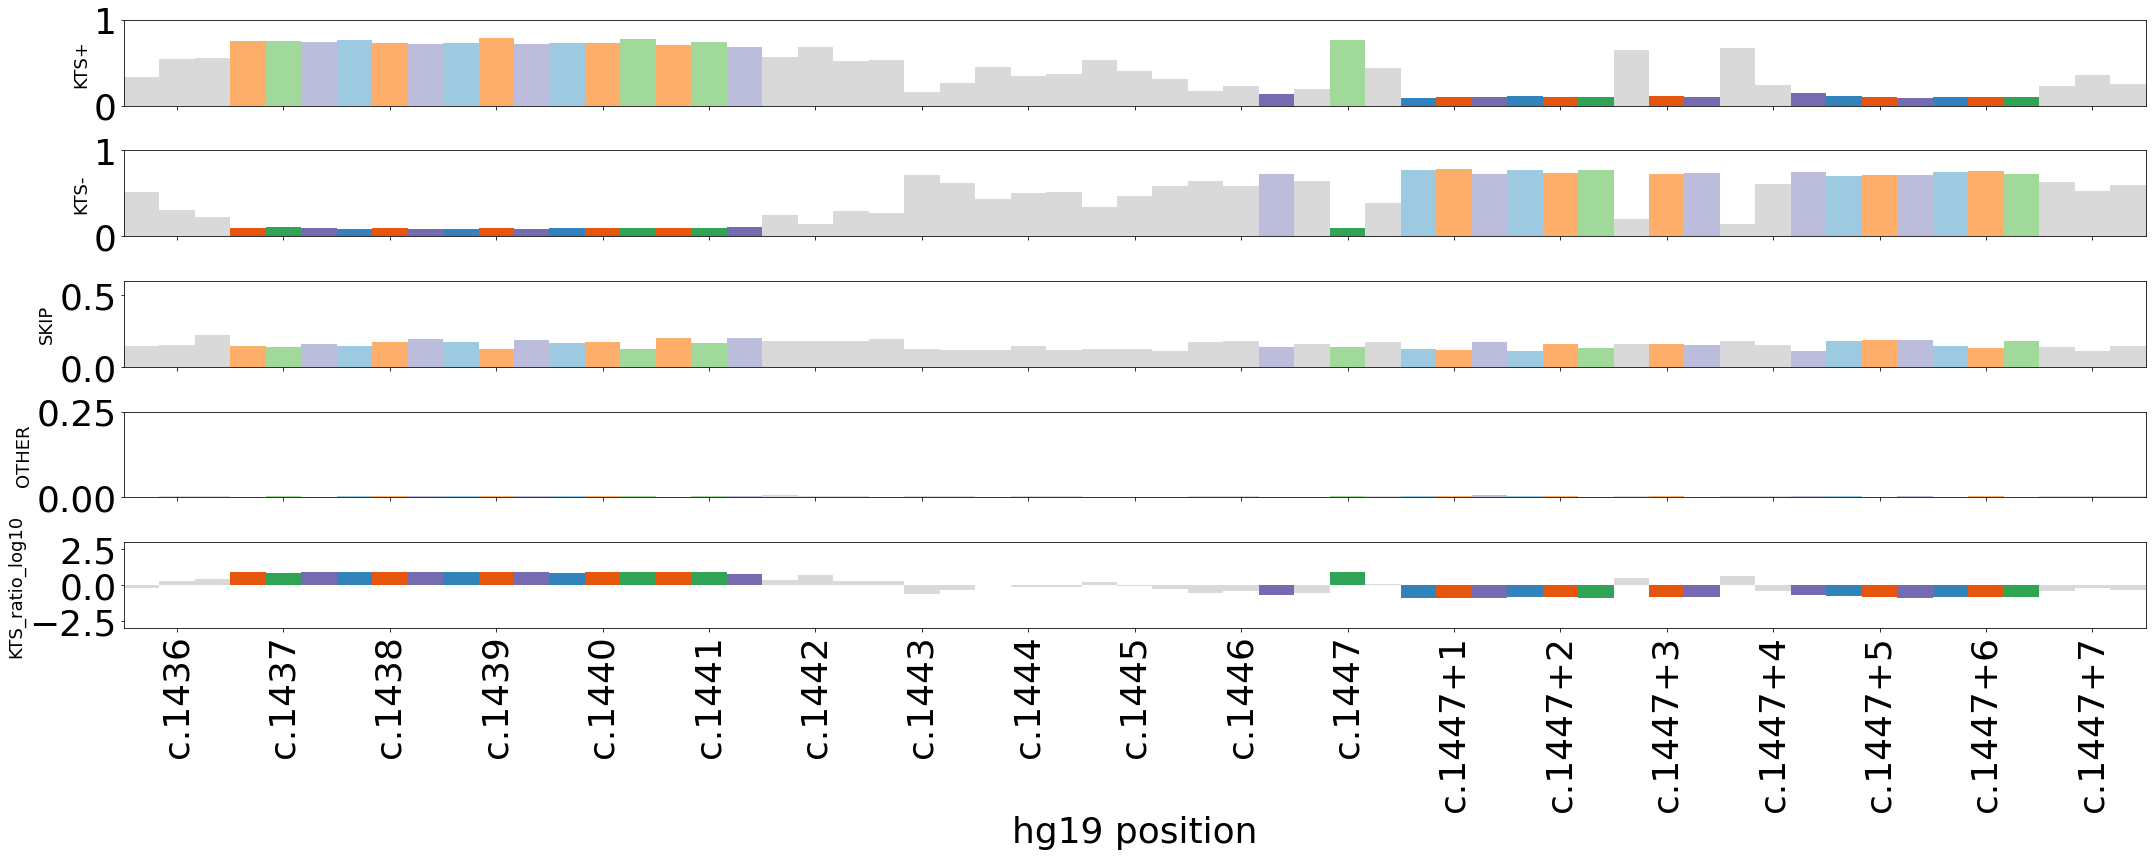

In [135]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1348, 1366 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv_fc3bi_d5PSI', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_fc3bi_d5PSI_KTS+', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI_KTS-', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc3bi_d5PSI' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, .6 ), ( 0, .25 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

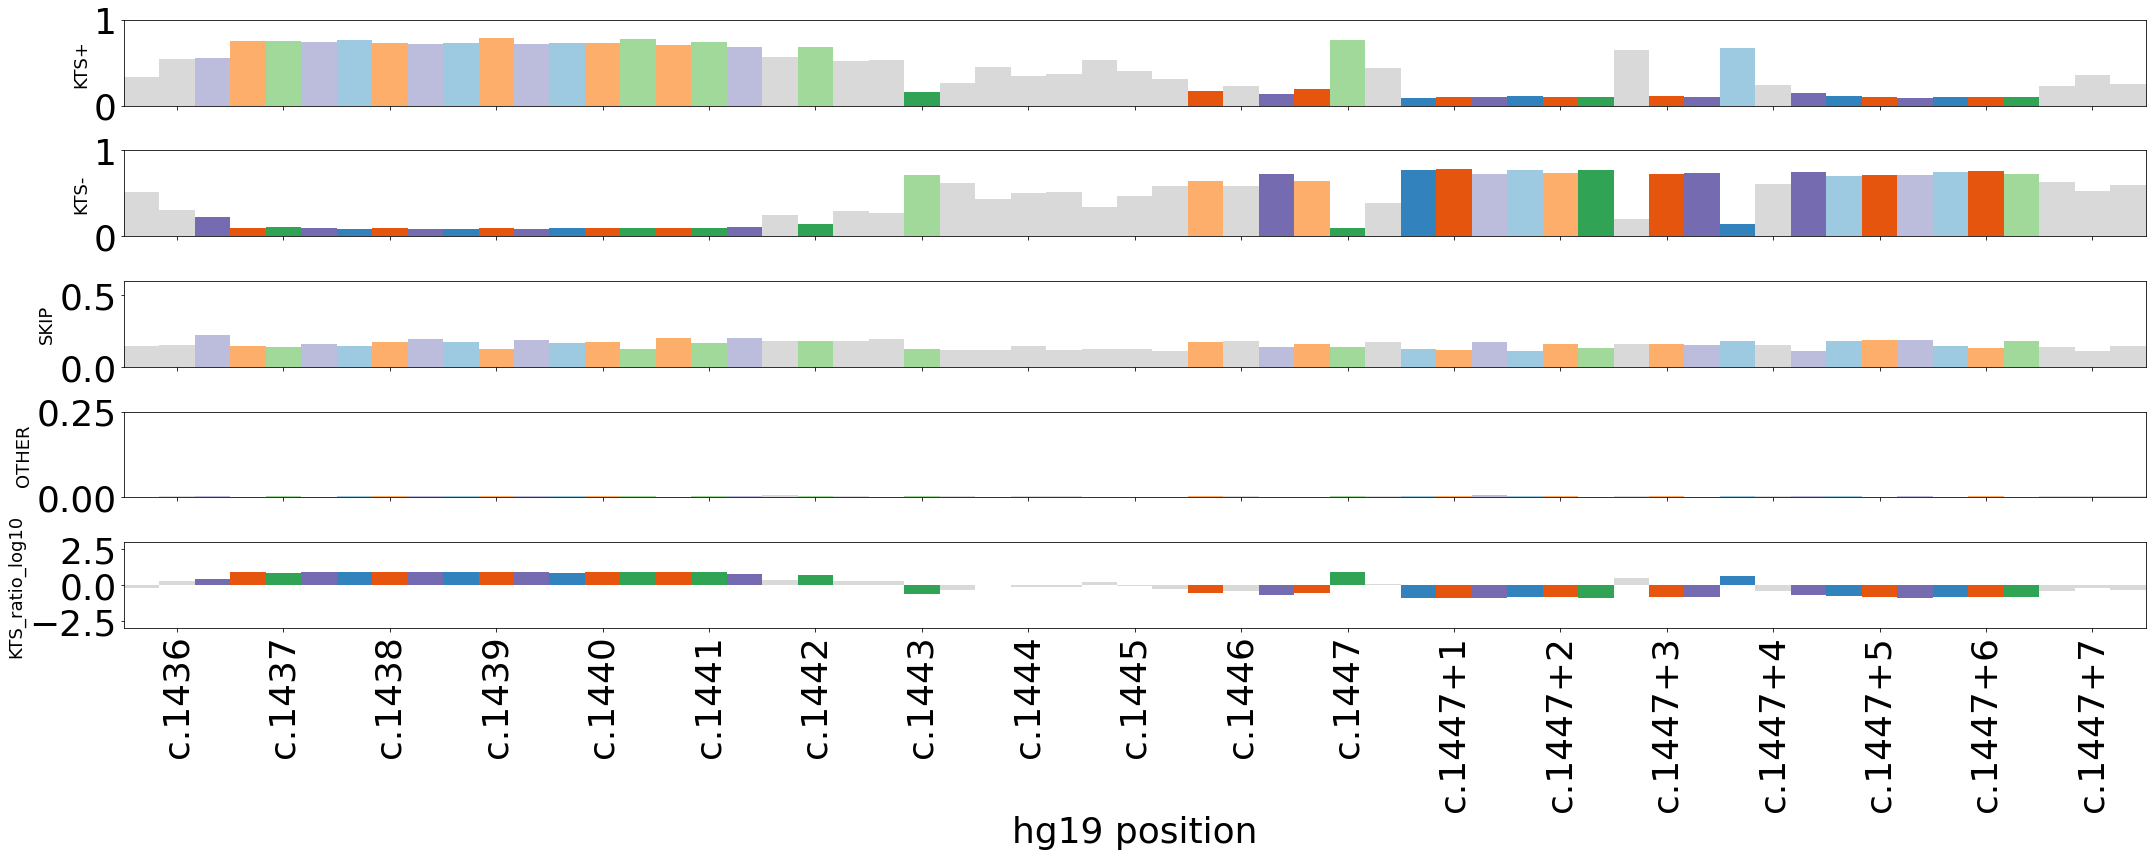

In [136]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ '.85', '.85', '.85', '.85' ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1348, 1366 ),
                          share_y = False,
                          legend = False,
                          darken_bars = [ ( 'sdv_fc2bi_d5PSI', [ l for idx,l in enumerate( light_colors ) if idx%4 == 2 ] ) ],
                          darken_bars2 = [ ( 'sdv_fc2bi_d5PSI_KTS+', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI_KTS-', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI_SKIP' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI_OTHER' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ),
                                          ( 'sdv_fc2bi_d5PSI' , [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, .6 ), ( 0, .25 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [140]:
view_cols = [ 'pos', 'ref_c', 'alt_c', 'hgvs_pos', 'wmean_KTS+', 'wmean_KTS-', 'wmean_bs_null_KTS+', 'wmean_bs_null_KTS-', 'zwmean_bs_null_KTS+', 'zwmean_bs_null_KTS-', 'fc_KTS+', 'fc_KTS-' ]

byvartbl_wide_m.loc[ ( byvartbl_wide_m.pos >= 1359 ) & ( byvartbl_wide_m.pos <= 1363 ) ][ view_cols ]

,pos,ref_c,alt_c,hgvs_pos,wmean_KTS+,wmean_KTS-,wmean_bs_null_KTS+,wmean_bs_null_KTS-,zwmean_bs_null_KTS+,zwmean_bs_null_KTS-,fc_KTS+,fc_KTS-
395,1359,A,T,c.1447,0.439645,0.384550,0.461533,0.411886,2.907415,0.667926,1.047416,0.995451
396,1359,A,G,c.1447,0.760930,0.098783,0.463837,0.409986,30.980548,-25.777157,1.866414,0.247664
397,1359,A,C,c.1447,0.190834,0.649325,0.463837,0.412639,-20.165949,25.109243,0.446963,1.779082
398,1360,G,T,c.1447+1,0.095431,0.725821,0.459347,0.408212,-38.907735,44.802188,0.220992,1.997233
399,1360,G,C,c.1447+1,0.101964,0.780630,0.464480,0.412179,-31.955880,42.202512,0.207706,2.165415
400,1360,G,A,c.1447+1,0.092515,0.777112,0.457644,0.411882,-43.560214,56.579986,0.191532,2.147615
401,1361,T,G,c.1447+2,0.097303,0.770757,0.464539,0.412016,-27.678350,35.695456,0.227397,2.095652
402,1361,T,C,c.1447+2,0.105608,0.735516,0.461702,0.412639,-26.097849,30.806265,0.174040,1.990020
403,1361,T,A,c.1447+2,0.108047,0.777934,0.467877,0.413735,-28.079500,35.723608,0.238598,1.961307
404,1362,G,T,c.1447+3,0.101979,0.742519,0.457587,0.413909,-44.317932,55.503303,0.223070,2.050727


In [193]:
view_cols = [ 'pos', 'ref_c', 'alt_c', 'hgvs_pos', 'sdv_fc2+', 'sdv_fc2bi', 'sdv_fc3bi', 'sdv_fc3bi_d5PSI', 'sdv_fc2bi_d5PSI', 'sdv_fc3bi_d5PSI_sum', 'sdv_fc2bi_d5PSI_sum' ]

byvartbl_wide_m.loc[ byvartbl_wide_m.lit_var_path ][ view_cols ]

,pos,ref_c,alt_c,hgvs_pos,sdv_fc2+,sdv_fc2bi,sdv_fc3bi,sdv_fc3bi_d5PSI,sdv_fc2bi_d5PSI,sdv_fc3bi_d5PSI_sum,sdv_fc2bi_d5PSI_sum
118,1266,G,A,c.1355-1,True,True,True,True,True,28,28
399,1360,G,C,c.1447+1,True,True,True,True,True,13,13
400,1360,G,A,c.1447+1,True,True,True,True,True,22,22
402,1361,T,C,c.1447+2,False,True,True,True,True,12,12
404,1362,G,T,c.1447+3,True,True,True,True,True,23,23
406,1362,G,A,c.1447+3,False,False,False,False,False,0,0
407,1363,C,T,c.1447+4,True,True,True,True,True,5,5
410,1364,G,T,c.1447+5,False,True,True,True,True,16,16
412,1364,G,A,c.1447+5,False,True,True,True,True,9,9
415,1365,T,A,c.1447+6,False,True,True,True,True,12,12


In [155]:
view_cols = [ 'pos', 'ref_c', 'alt_c', 'hgvs_pos', 'n_bc_passfilt_med', 'wmean_KTS+', 'wmean_KTS-', 'wmean_SKIP', 'wmean_OTHER', 'zwmean_bs_null_KTS+', 'zwmean_bs_null_KTS-', 'fc_KTS+', 'fc_KTS-' ]

byvartbl_wide_m.loc[ byvartbl_wide_m.lit_var_path ][ view_cols ]

,pos,ref_c,alt_c,hgvs_pos,n_bc_passfilt_med,wmean_KTS+,wmean_KTS-,wmean_SKIP,wmean_OTHER,zwmean_bs_null_KTS+,zwmean_bs_null_KTS-,fc_KTS+,fc_KTS-
118,1266,G,A,c.1355-1,56.5,0.072217,0.062558,0.778822,0.083959,-33.141702,-31.840165,0.156057,0.136196
399,1360,G,C,c.1447+1,35.5,0.101964,0.780630,0.116132,0.002623,-31.955880,42.202512,0.207706,2.165415
400,1360,G,A,c.1447+1,66.5,0.092515,0.777112,0.125939,0.005345,-43.560214,56.579986,0.191532,2.147615
402,1361,T,C,c.1447+2,23.0,0.105608,0.735516,0.159181,0.003000,-26.097849,30.806265,0.174040,1.990020
404,1362,G,T,c.1447+3,84.5,0.101979,0.742519,0.155062,0.002305,-44.317932,55.503303,0.223070,2.050727
406,1362,G,A,c.1447+3,33.5,0.643376,0.198240,0.157233,0.003552,23.687485,-18.177518,1.546778,0.518381
407,1363,C,T,c.1447+4,33.5,0.142569,0.747727,0.108268,0.003254,-26.384721,36.380144,0.323140,2.081174
410,1364,G,T,c.1447+5,49.5,0.094937,0.713098,0.189441,0.003499,-39.247528,42.814824,0.212648,1.914612
412,1364,G,A,c.1447+5,47.0,0.114138,0.705921,0.178405,0.003849,-32.555598,38.251434,0.256099,1.937210
415,1365,T,A,c.1447+6,31.0,0.102960,0.746363,0.148312,0.002494,-29.879589,36.244764,0.233961,1.990407


In [145]:
view_cols = [ 'pos', 'ref_c', 'alt_c', 'hgvs_pos', 'wmean_KTS+', 'wmean_KTS-', 'wmean_SKIP', 'wmean_OTHER', 'zwmean_bs_null_KTS+', 'zwmean_bs_null_KTS-', 'fc_KTS+', 'fc_KTS-', 'fc_SKIP', 'fc_OTHER' ]

byvartbl_wide_m.loc[ byvartbl_wide_m.lit_var_path ][ view_cols ]

,pos,ref_c,alt_c,hgvs_pos,wmean_KTS+,wmean_KTS-,wmean_SKIP,wmean_OTHER,zwmean_bs_null_KTS+,zwmean_bs_null_KTS-,fc_KTS+,fc_KTS-,fc_SKIP,fc_OTHER
118,1266,G,A,c.1355-1,0.072217,0.062558,0.778822,0.083959,-33.141702,-31.840165,0.156057,0.136196,4.798987,33.900516
399,1360,G,C,c.1447+1,0.101964,0.780630,0.116132,0.002623,-31.955880,42.202512,0.207706,2.165415,0.469493,0.293755
400,1360,G,A,c.1447+1,0.092515,0.777112,0.125939,0.005345,-43.560214,56.579986,0.191532,2.147615,0.534359,0.733864
402,1361,T,C,c.1447+2,0.105608,0.735516,0.159181,0.003000,-26.097849,30.806265,0.174040,1.990020,0.613299,0.543383
404,1362,G,T,c.1447+3,0.101979,0.742519,0.155062,0.002305,-44.317932,55.503303,0.223070,2.050727,0.646286,0.565188
406,1362,G,A,c.1447+3,0.643376,0.198240,0.157233,0.003552,23.687485,-18.177518,1.546778,0.518381,0.515745,0.538154
407,1363,C,T,c.1447+4,0.142569,0.747727,0.108268,0.003254,-26.384721,36.380144,0.323140,2.081174,0.469576,0.000000
410,1364,G,T,c.1447+5,0.094937,0.713098,0.189441,0.003499,-39.247528,42.814824,0.212648,1.914612,0.842264,0.566231
412,1364,G,A,c.1447+5,0.114138,0.705921,0.178405,0.003849,-32.555598,38.251434,0.256099,1.937210,0.754054,0.617851
415,1365,T,A,c.1447+6,0.102960,0.746363,0.148312,0.002494,-29.879589,36.244764,0.233961,1.990407,0.576787,0.827062


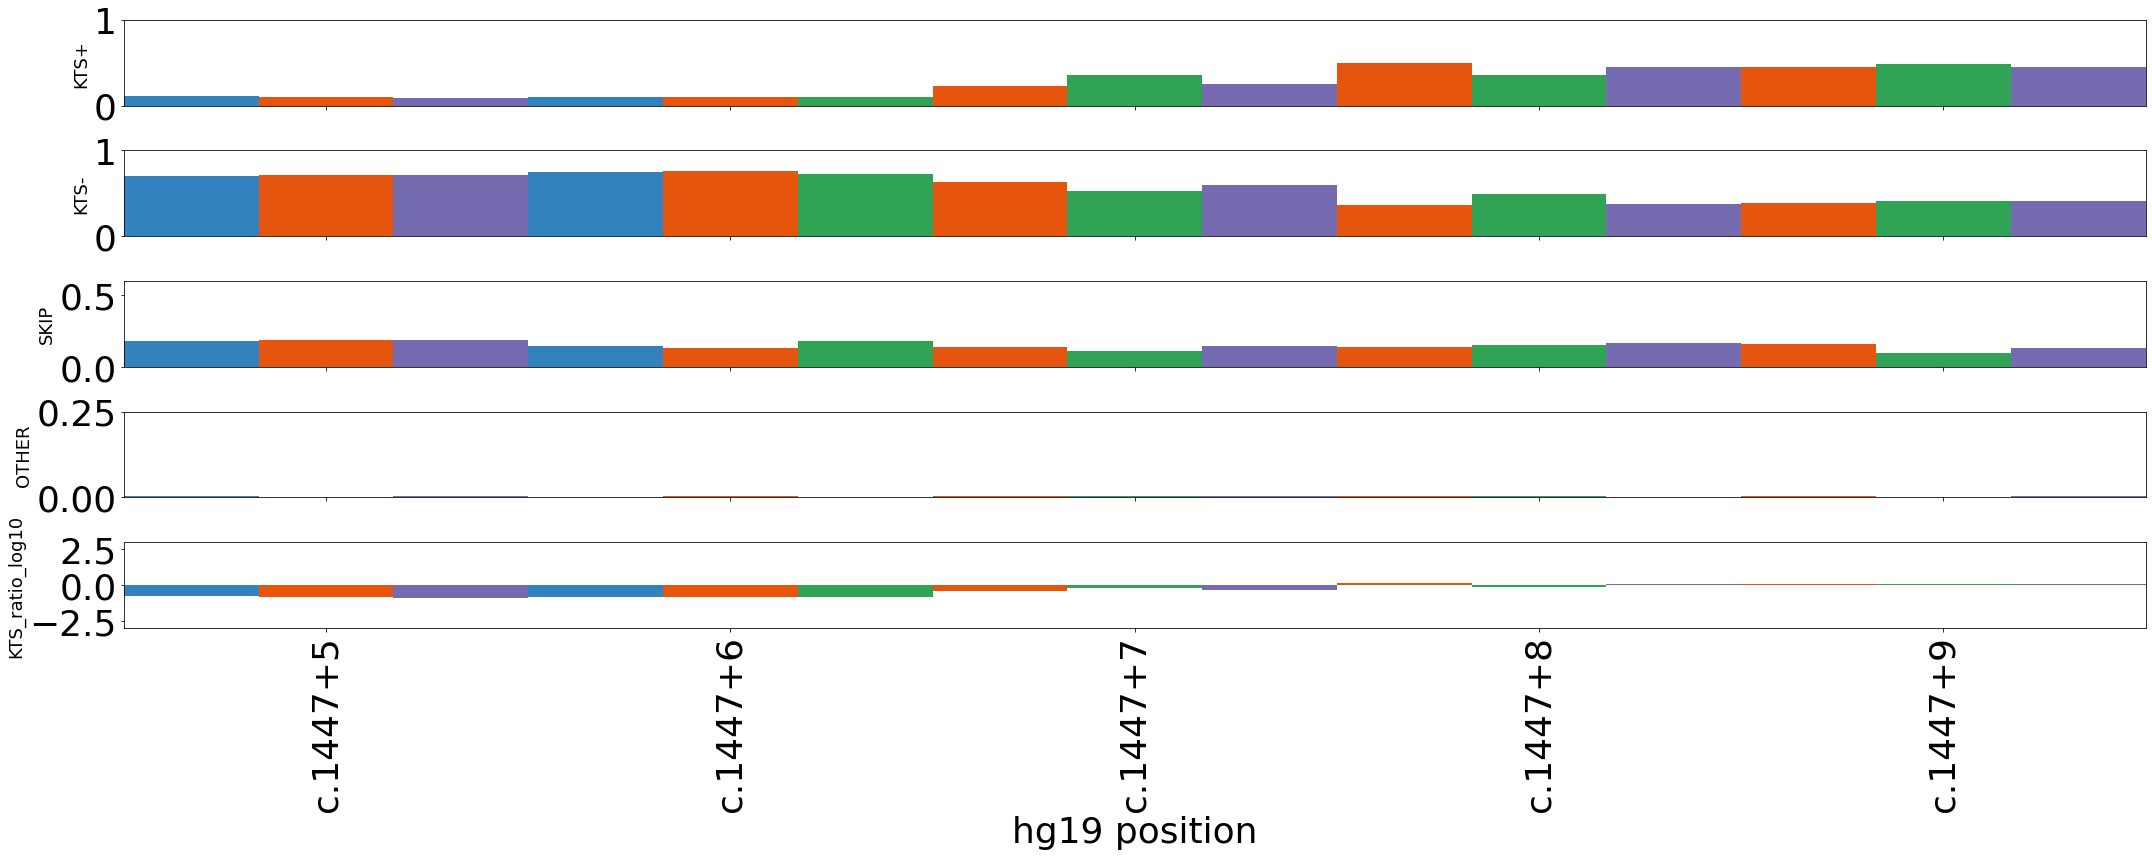

In [150]:
sp.sat_subplots_wrapper( byvartbl_sat.rename( columns = { 'alt': 'a',
                                                          'ref': 'r',
                                                           'alt_c': 'alt',
                                                           'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1364, 1368 ),
                          share_y = False,
                          legend = False,
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, .6 ), ( 0, .25 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) and '_bs_' not in col ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [165]:
for samp in byvartbl_long[ 'sample' ].unique():
    
    byvartbl_wide_m = pp.sdv_by_iso( byvartbl_wide_m,
                                     iso_names,
                                     samp + '_zwmean_bs_null_',
                                    ss.norm.ppf( 1 - bonfer ),
                                   samp + '_fc_',
                                   3,
                                   out_col_stem = samp + '_sdv_fc3bi_d5PSI_',
                                   chg_null_col_stem = samp + '_wmean_bs_null_',
                                   chg_meas_col_stem = samp + '_wmean_',
                                   chg_thresh = .05,
                                   bi_directional = True
                                   )

In [185]:
for samp in byvartbl_long[ 'sample' ].unique():

    byvartbl_wide_m[ samp + '_sdv_fc3bi_d5PSI' ] = byvartbl_wide_m[ [ samp + '_sdv_fc3bi_d5PSI_' + iso for iso in iso_names ] ].any( axis = 'columns' )

In [188]:
byvartbl_wide_m[ 'sdv_fc3bi_d5PSI_sum' ] = byvartbl_wide_m[ [ samp + '_sdv_fc3bi_d5PSI' for samp in byvartbl_long[ 'sample' ].unique() ] ].sum( axis = 1 )

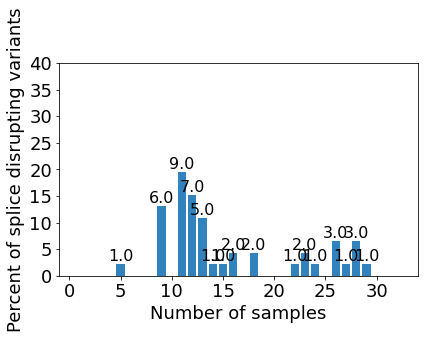

In [189]:
sp.barplot_per_repeat( byvartbl_wide_m.loc[ byvartbl_wide_m[ 'sdv_fc3bi_d5PSI' ] ],
                    'sdv_fc3bi_d5PSI_sum',
                    32,
                    ylim = ( 0, 40 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    #savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )

In [178]:
for samp in byvartbl_long[ 'sample' ].unique():
    
    byvartbl_wide_m = pp.sdv_by_iso( byvartbl_wide_m,
                                     iso_names,
                                     samp + '_zwmean_bs_null_',
                                    ss.norm.ppf( 1 - bonfer ),
                                   samp + '_fc_',
                                   3,
                                   out_col_stem = samp + '_sdv_fc2bi_d5PSI_',
                                   chg_null_col_stem = samp + '_wmean_bs_null_',
                                   chg_meas_col_stem = samp + '_wmean_',
                                   chg_thresh = .05,
                                   bi_directional = True
                                   )

In [190]:
for samp in byvartbl_long[ 'sample' ].unique():

    byvartbl_wide_m[ samp + '_sdv_fc2bi_d5PSI' ] = byvartbl_wide_m[ [ samp + '_sdv_fc2bi_d5PSI_' + iso for iso in iso_names ] ].any( axis = 'columns' )

In [191]:
byvartbl_wide_m[ 'sdv_fc2bi_d5PSI_sum' ] = byvartbl_wide_m[ [ samp + '_sdv_fc2bi_d5PSI' for samp in byvartbl_long[ 'sample' ].unique() ] ].sum( axis = 1 )

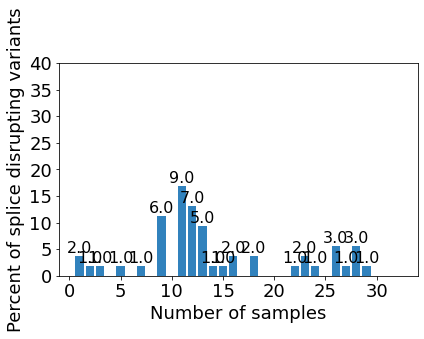

In [192]:
sp.barplot_per_repeat( byvartbl_wide_m.loc[ byvartbl_wide_m[ 'sdv_fc2bi_d5PSI' ] ],
                    'sdv_fc2bi_d5PSI_sum',
                    32,
                    ylim = ( 0, 40 ),
                    ylabel = 'Percent of splice disrupting variants',
                    xlabel = 'Number of samples',
                    #savefig = plot_out + 'sdv_by_samp.pdf',
                    color = light_colors[ 0 ]
                  )

In [195]:
byvartbl_wide_m.loc[ ( byvartbl_wide_m.pos >= 1257 ) & ( byvartbl_wide_m.pos < 1267 ) ][ [ 'pos', 'ref', 'alt', 'hgvs_pos', 'wmean_KTS+', 'wmean_KTS-', 'wmean_SKIP', 'wmean_OTHER' ] ]

,pos,ref,alt,hgvs_pos,wmean_KTS+,wmean_KTS-,wmean_SKIP,wmean_OTHER
90,1257,C,A,c.1355-10,0.344644,0.300596,0.354755,0.002168
91,1257,C,G,c.1355-10,0.456717,0.399250,0.142420,0.003031
92,1257,C,T,c.1355-10,0.386872,0.342354,0.270311,0.002182
93,1258,A,G,c.1355-9,0.373114,0.325503,0.300123,0.002019
94,1258,A,T,c.1355-9,0.274168,0.226384,0.390371,0.108917
95,1259,G,A,c.1355-8,0.411070,0.382052,0.204734,0.003873
96,1259,G,C,c.1355-8,0.377787,0.324961,0.295253,0.003298
97,1259,G,T,c.1355-8,0.424869,0.359781,0.214317,0.003366
98,1260,G,A,c.1355-7,0.413381,0.360783,0.225605,0.002408
99,1260,G,C,c.1355-7,0.452698,0.381856,0.162914,0.003495


In [197]:
byvartbl_wide_m.loc[ ( byvartbl_wide_m.pos >= 1247 ) & ( byvartbl_wide_m.pos < 1257 ) ][ [ 'pos', 'ref', 'alt', 'hgvs_pos', 'wmean_KTS+', 'wmean_KTS-', 'wmean_SKIP', 'wmean_OTHER' ] ]

,pos,ref,alt,hgvs_pos,wmean_KTS+,wmean_KTS-,wmean_SKIP,wmean_OTHER
60,1247,C,A,c.1355-20,0.385921,0.363649,0.248842,0.003287
61,1247,C,G,c.1355-20,0.432207,0.386000,0.173909,0.009201
62,1247,C,T,c.1355-20,0.451448,0.408848,0.138158,0.003001
63,1248,T,A,c.1355-19,0.335426,0.296904,0.367419,0.002468
64,1248,T,C,c.1355-19,0.363564,0.331906,0.297169,0.008177
65,1248,T,G,c.1355-19,0.446573,0.374930,0.177028,0.002186
66,1249,G,A,c.1355-18,0.468138,0.400340,0.130841,0.002322
67,1249,G,C,c.1355-18,0.472409,0.393474,0.133586,0.002268
68,1249,G,T,c.1355-18,0.452071,0.395573,0.150768,0.002563
69,1250,G,A,c.1355-17,0.347541,0.306309,0.344879,0.002562
